## Convergence in large scale cases

In [1]:
from bb import *

def solve_bb(instance, max_ant=5, max_iter=10000, policy='default', policy_type='gnn', oracle_opt=None):
    t1 = time.time()
    if policy_type == 'default':
        env = BBenv(observation_function=Observation, epsilon=0.001)
    elif policy_type == 'gnn':
        env = BBenv(observation_function=Observation, epsilon=0.001)
    elif policy_type == 'linear':
        env = BBenv(observation_function=LinearObservation, epsilon=0.001)
    elif policy_type == 'oracle':
        env = BBenv(observation_function=Observation, epsilon=0.001)
        pass

    branching_policy = DefaultBranchingPolicy()

    t1 = time.time()

    env.reset(instance, max_ant=max_ant)
    timestep = 0
    done = False
    ub_list = []
    lb_list = []
    while timestep < max_iter and len(env.nodes)>0 and not done:
        print('timestep {}, U {}, L {}, len_nodes {}, depth_tree {}'.format(timestep, env.global_U, env.global_L, len(env.nodes), env.active_node.depth))
        env.fathom_nodes()
        if len(env.nodes) == 0:
            break
        node_id, node_feats, label = env.select_node()
        
        if len(env.nodes) == 0:
            break
        # prune_node = env.prune(node_feats)
        # if prune_node:
        #     env.delete_node(node_id)
        #     continue
        # else:
        branching_var = branching_policy.select_variable(node_feats, env.action_set_indices, env=env)
        # print(branching_var)
        # print('selected node z_sol {}, z_mask {}, z_feas {}'.format(env.nodes[node_id].z_sol, env.nodes[node_id].z_mask, env.nodes[node_id].z_feas))

        done = env.push_children(branching_var, node_id)
        timestep = timestep+1

        if env.is_terminal():
            break
        ub_list.append(env.global_U)
        lb_list.append(env.global_L)


    print('ended')
    print('result', env.z_incumbent.copy(), np.linalg.norm(env.w_incumbent,2)**2)
    # returns the solution, objective value, timestep and the time taken
    return (env.z_incumbent.copy(), env.w_incumbent.copy()), env.global_U, timestep , time.time()-t1, ub_list, lb_list


In [9]:
import torch
import torch.nn as nn
import numpy as np
import time 
from models.gnn_policy import GNNPolicy, GNNNodeSelectionPolicy
from models.fcn_policy import FCNNodeSelectionLinearPolicy
from models.gnn_dataset import get_graph_from_obs
from models.setting import MODEL_PATH
from single_group_as_bm.observation import *
# from single_group_as_bm.solve_relaxation import qp_relaxed, solve_relaxed_with_selected_antennas, cvxpy_relaxed
import numpy.ma as ma

min_bound_gap = 0.01

np.random.seed(seed = 100)
N = 8
M = 32
max_ant = 4

u_avg = 0
t_avg = 0
tstep_avg = 0
for i in range(1):
    H = np.random.randn(N, M) + 1j*np.random.randn(N,M)    
    instance = np.stack((np.real(H), np.imag(H)), axis=0)
    z_inc, global_U, timesteps, t, ub_list, lb_list = solve_bb(instance, max_ant=max_ant, max_iter = 7000)
    u_avg += global_U
    t_avg += t
    tstep_avg += timesteps

print(u_avg, t_avg, tstep_avg, u_avg)

timestep 0, U 41.095528041380675, L 0.043652173194608304, len_nodes 1, depth_tree 1
node depth at global U update 2
timestep 1, U 15.766953805641014, L 0.04365217198211754, len_nodes 4, depth_tree 1
node depth at global U update 3
timestep 2, U 5.437469501165462, L 0.04369196882166266, len_nodes 7, depth_tree 2
timestep 3, U 5.437469501165462, L 0.04423326709103987, len_nodes 10, depth_tree 2
timestep 4, U 5.437469501165462, L 0.04446930692326721, len_nodes 13, depth_tree 2
timestep 5, U 5.437469501165462, L 0.08399203656618824, len_nodes 16, depth_tree 2
timestep 6, U 5.437469501165462, L 0.08399204275214067, len_nodes 19, depth_tree 3
timestep 7, U 5.437469501165462, L 0.08403145276661328, len_nodes 22, depth_tree 4
timestep 8, U 5.437469501165462, L 0.08404901396723677, len_nodes 25, depth_tree 4
timestep 9, U 5.437469501165462, L 0.08404902441419114, len_nodes 28, depth_tree 3
timestep 10, U 5.437469501165462, L 0.08416698467522368, len_nodes 31, depth_tree 4
timestep 11, U 5.43746

timestep 91, U 2.5153703459564962, L 0.09936659904823682, len_nodes 253, depth_tree 3
timestep 92, U 2.5153703459564962, L 0.0993767860194441, len_nodes 256, depth_tree 4
timestep 93, U 2.5153703459564962, L 0.09947277325324232, len_nodes 259, depth_tree 4
timestep 94, U 2.5153703459564962, L 0.09947314803486211, len_nodes 262, depth_tree 4
timestep 95, U 2.5153703459564962, L 0.10170036809138962, len_nodes 265, depth_tree 4
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 96, U 2.5153703459564962, L 0.10170037657122703, len_nodes 266, depth_tree 5
timestep 97, U 2.5153703459564962, L 0.10189863573216236, len_nodes 269, depth_tree 6
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 98, U 2.5153703459564962, L 0.10203804009627465, len_nodes 268, depth_tree 5
relaxed: not optimal, may be infeasible
timestep 99, U 2.5153703459564962

relaxed: not optimal, may be infeasible
timestep 167, U 2.5153703459564962, L 0.12765273015753015, len_nodes 431, depth_tree 5
timestep 168, U 2.5153703459564962, L 0.12797767882174785, len_nodes 434, depth_tree 6
timestep 169, U 2.5153703459564962, L 0.12797771523426468, len_nodes 437, depth_tree 5
timestep 170, U 2.5153703459564962, L 0.12852508304589239, len_nodes 440, depth_tree 6
timestep 171, U 2.5153703459564962, L 0.12852511782643908, len_nodes 443, depth_tree 5
timestep 172, U 2.5153703459564962, L 0.1285253489126806, len_nodes 446, depth_tree 6
timestep 173, U 2.5153703459564962, L 0.12874606801522076, len_nodes 449, depth_tree 6
timestep 174, U 2.5153703459564962, L 0.1289960330103296, len_nodes 452, depth_tree 6
timestep 175, U 2.5153703459564962, L 0.12903662569531732, len_nodes 455, depth_tree 5
timestep 176, U 2.5153703459564962, L 0.12914305980853097, len_nodes 458, depth_tree 5
timestep 177, U 2.5153703459564962, L 0.12923201445362822, len_nodes 461, depth_tree 5
times

timestep 254, U 1.4632334195688568, L 0.1386195144464925, len_nodes 667, depth_tree 6
timestep 255, U 1.4632334195688568, L 0.13869569442028298, len_nodes 670, depth_tree 7
timestep 256, U 1.4632334195688568, L 0.13869570098754336, len_nodes 673, depth_tree 5
timestep 257, U 1.4632334195688568, L 0.1386987484322849, len_nodes 676, depth_tree 6
timestep 258, U 1.4632334195688568, L 0.13898474678258674, len_nodes 679, depth_tree 6
timestep 259, U 1.4632334195688568, L 0.1390237552910996, len_nodes 682, depth_tree 5
antennas: not optimal, may be infeasible
timestep 260, U 1.4632334195688568, L 0.1392304728796533, len_nodes 684, depth_tree 7
timestep 261, U 1.4632334195688568, L 0.13931821343433948, len_nodes 687, depth_tree 7
timestep 262, U 1.4632334195688568, L 0.1393401541344262, len_nodes 690, depth_tree 6
timestep 263, U 1.4632334195688568, L 0.1395341460173363, len_nodes 693, depth_tree 6
timestep 264, U 1.4632334195688568, L 0.13956205711124653, len_nodes 696, depth_tree 5
timestep

relaxed: not optimal, may be infeasible
timestep 342, U 1.4632334195688568, L 0.14855270221615685, len_nodes 890, depth_tree 5
timestep 343, U 1.4632334195688568, L 0.1486936804731102, len_nodes 893, depth_tree 6
timestep 344, U 1.4632334195688568, L 0.1488067911876121, len_nodes 896, depth_tree 6
timestep 345, U 1.4632334195688568, L 0.1488068122838201, len_nodes 899, depth_tree 5
timestep 346, U 1.4632334195688568, L 0.1489281276218674, len_nodes 902, depth_tree 6
timestep 347, U 1.4632334195688568, L 0.1489582755539772, len_nodes 905, depth_tree 7
timestep 348, U 1.4632334195688568, L 0.1490791690226048, len_nodes 908, depth_tree 5
timestep 349, U 1.4632334195688568, L 0.1490791836833424, len_nodes 911, depth_tree 6
timestep 350, U 1.4632334195688568, L 0.14919064099013768, len_nodes 912, depth_tree 7
timestep 351, U 1.4632334195688568, L 0.1492913264653001, len_nodes 915, depth_tree 7
relaxed: not optimal, may be infeasible
timestep 352, U 1.4632334195688568, L 0.14929134493310514,

timestep 429, U 1.4632334195688568, L 0.1565619531211072, len_nodes 1108, depth_tree 6
timestep 430, U 1.4632334195688568, L 0.1574239625128385, len_nodes 1111, depth_tree 7
timestep 431, U 1.4632334195688568, L 0.15742394508959642, len_nodes 1112, depth_tree 7
timestep 432, U 1.4632334195688568, L 0.15743983586416174, len_nodes 1113, depth_tree 8
relaxed: not optimal, may be infeasible
timestep 433, U 1.4632334195688568, L 0.15743985701818186, len_nodes 1115, depth_tree 5
timestep 434, U 1.4632334195688568, L 0.1575371264277501, len_nodes 1118, depth_tree 6
timestep 435, U 1.4632334195688568, L 0.15755123282549593, len_nodes 1120, depth_tree 6
timestep 436, U 1.4632334195688568, L 0.15768915684965643, len_nodes 1123, depth_tree 5
timestep 437, U 1.4632334195688568, L 0.15779500105956076, len_nodes 1124, depth_tree 8
timestep 438, U 1.4632334195688568, L 0.15779500082651865, len_nodes 1125, depth_tree 7
timestep 439, U 1.4632334195688568, L 0.15789629479065598, len_nodes 1126, depth_tr

timestep 511, U 1.4632334195688568, L 0.16483796824035693, len_nodes 1296, depth_tree 8
antennas: not optimal, may be infeasible
timestep 512, U 1.4632334195688568, L 0.16489574568805002, len_nodes 1296, depth_tree 9
relaxed: not optimal, may be infeasible
timestep 513, U 1.4632334195688568, L 0.16527332634030084, len_nodes 1298, depth_tree 6
timestep 514, U 1.4632334195688568, L 0.16545015373948013, len_nodes 1301, depth_tree 6
timestep 515, U 1.4632334195688568, L 0.16580616119540573, len_nodes 1303, depth_tree 6
timestep 516, U 1.4632334195688568, L 0.16588594479546837, len_nodes 1304, depth_tree 9
timestep 517, U 1.4632334195688568, L 0.16589243208406396, len_nodes 1305, depth_tree 7
timestep 518, U 1.4632334195688568, L 0.16599394861646014, len_nodes 1306, depth_tree 7
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 519, U 1.4632334195688568, L 0.16611100019712396, len_nodes 1307, depth_tree 6
antennas: not optimal, may be infeasible
timest

timestep 587, U 1.4632334195688568, L 0.17364666043183585, len_nodes 1433, depth_tree 7
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 588, U 1.4632334195688568, L 0.17381979644174644, len_nodes 1432, depth_tree 6
timestep 589, U 1.4632334195688568, L 0.17381979589897623, len_nodes 1433, depth_tree 7
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 590, U 1.4632334195688568, L 0.17422760004795187, len_nodes 1432, depth_tree 8
relaxed: not optimal, may be infeasible
timestep 591, U 1.4632334195688568, L 0.17422760727295508, len_nodes 1434, depth_tree 5
timestep 592, U 1.4632334195688568, L 0.17422876506915724, len_nodes 1437, depth_tree 6
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 593, U 1.4632334195688568, L 0.17459096484302972, len_nodes 1436, depth_tree 6
timestep 594, U 1.4632334195688568, L 0.174590984855071, len_nodes 1439, depth_tree 6
timestep 595, U 

timestep 668, U 1.4632334195688568, L 0.18046302041000906, len_nodes 1600, depth_tree 7
timestep 669, U 1.4632334195688568, L 0.18046305459101203, len_nodes 1603, depth_tree 5
timestep 670, U 1.4632334195688568, L 0.18048515558580736, len_nodes 1606, depth_tree 6
timestep 671, U 1.4632334195688568, L 0.18054108962500678, len_nodes 1609, depth_tree 6
timestep 672, U 1.4632334195688568, L 0.1805411077288708, len_nodes 1612, depth_tree 6
timestep 673, U 1.4632334195688568, L 0.1806562925333577, len_nodes 1615, depth_tree 7
timestep 674, U 1.4632334195688568, L 0.18068638298628836, len_nodes 1618, depth_tree 7
timestep 675, U 1.4632334195688568, L 0.18068637992917416, len_nodes 1619, depth_tree 7
timestep 676, U 1.4632334195688568, L 0.18076312652818727, len_nodes 1620, depth_tree 8
antennas: not optimal, may be infeasible
timestep 677, U 1.4632334195688568, L 0.1808939258036038, len_nodes 1620, depth_tree 8
timestep 678, U 1.4632334195688568, L 0.18089396413308262, len_nodes 1623, depth_t

relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 746, U 1.4632334195688568, L 0.18802492422455655, len_nodes 1744, depth_tree 6
relaxed: not optimal, may be infeasible
timestep 747, U 1.4632334195688568, L 0.1880249478071573, len_nodes 1746, depth_tree 5
timestep 748, U 1.4632334195688568, L 0.1882844549327486, len_nodes 1749, depth_tree 6
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 749, U 1.4632334195688568, L 0.1883058999449219, len_nodes 1750, depth_tree 7
timestep 750, U 1.4632334195688568, L 0.18838194778659137, len_nodes 1753, depth_tree 7
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 751, U 1.4632334195688568, L 0.18838195234077965, len_nodes 1754, depth_tree 6
relaxed: not optimal, may be infeasible
timestep 752, U 1.4632334195688568, L 0.1883829605395657, len_nodes 1756, depth_tree 7
antennas: not optimal, may be infeasible
timestep 753, U 1.4632334

timestep 823, U 1.4632334195688568, L 0.19663988428015697, len_nodes 1898, depth_tree 6
relaxed: not optimal, may be infeasible
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 824, U 1.4632334195688568, L 0.19678864976036994, len_nodes 1898, depth_tree 6
timestep 825, U 1.4632334195688568, L 0.19678867213330026, len_nodes 1901, depth_tree 5
timestep 826, U 1.4632334195688568, L 0.1969223344765433, len_nodes 1904, depth_tree 6
timestep 827, U 1.4632334195688568, L 0.1975548824116571, len_nodes 1907, depth_tree 6
timestep 828, U 1.4632334195688568, L 0.19774275161597749, len_nodes 1909, depth_tree 7
timestep 829, U 1.4632334195688568, L 0.19778017406162576, len_nodes 1910, depth_tree 8
timestep 830, U 1.4632334195688568, L 0.198060649868423, len_nodes 1913, depth_tree 7
antennas: not optimal, may be infeasible
timestep 831, U 1.4632334195688568, L 0.19806064955410757, len_nodes 1913, depth_tree 7
timestep 832, U 1.4632334195688568, L 0.198078659

timestep 906, U 1.4632334195688568, L 0.20943752208044036, len_nodes 2023, depth_tree 7
antennas: not optimal, may be infeasible
timestep 907, U 1.4632334195688568, L 0.2094374376211457, len_nodes 2023, depth_tree 7
timestep 908, U 1.4632334195688568, L 0.2095996312492555, len_nodes 2024, depth_tree 8
antennas: not optimal, may be infeasible
timestep 909, U 1.4632334195688568, L 0.2095996311687243, len_nodes 2024, depth_tree 8
timestep 910, U 1.4632334195688568, L 0.20960749744977808, len_nodes 2025, depth_tree 9
timestep 911, U 1.4632334195688568, L 0.20967118199134982, len_nodes 2026, depth_tree 8
antennas: not optimal, may be infeasible
timestep 912, U 1.4632334195688568, L 0.20967817446043163, len_nodes 2028, depth_tree 7
antennas: not optimal, may be infeasible
timestep 913, U 1.4632334195688568, L 0.20968528409699067, len_nodes 2030, depth_tree 7
timestep 914, U 1.4632334195688568, L 0.21010015093478607, len_nodes 2033, depth_tree 6
timestep 915, U 1.4632334195688568, L 0.2101614

timestep 990, U 1.4632334195688568, L 0.21606467773492702, len_nodes 2150, depth_tree 5
timestep 991, U 1.4632334195688568, L 0.21624035067767616, len_nodes 2152, depth_tree 7
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 992, U 1.4632334195688568, L 0.21624036620649809, len_nodes 2152, depth_tree 5
timestep 993, U 1.4632334195688568, L 0.2162926513796399, len_nodes 2155, depth_tree 6
antennas: not optimal, may be infeasible
timestep 994, U 1.4632334195688568, L 0.21630210926333482, len_nodes 2157, depth_tree 7
antennas: not optimal, may be infeasible
timestep 995, U 1.4632334195688568, L 0.2163021455440748, len_nodes 2159, depth_tree 6
timestep 996, U 1.4632334195688568, L 0.21645855847234702, len_nodes 2162, depth_tree 7
antennas: not optimal, may be infeasible
timestep 997, U 1.4632334195688568, L 0.21651382089050658, len_nodes 2164, depth_tree 7
relaxed: not optimal, may be infeasible
relaxed: not op

timestep 1068, U 1.4632334195688568, L 0.2222578838783482, len_nodes 2285, depth_tree 7
antennas: not optimal, may be infeasible
timestep 1069, U 1.4632334195688568, L 0.22245337953186262, len_nodes 2287, depth_tree 7
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 1070, U 1.4632334195688568, L 0.22251976174373841, len_nodes 2288, depth_tree 7
timestep 1071, U 1.4632334195688568, L 0.22257962057505365, len_nodes 2289, depth_tree 8
timestep 1072, U 1.4632334195688568, L 0.22263821419095287, len_nodes 2292, depth_tree 7
timestep 1073, U 1.4632334195688568, L 0.22283495426684474, len_nodes 2295, depth_tree 7
timestep 1074, U 1.4632334195688568, L 0.22287538616897765, len_nodes 2296, depth_tree 8
timestep 1075, U 1.4632334195688568, L 0.2229479280763375, len_nodes 2297, depth_tree 8
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 1076, U 1.4632334195688568, L 0.22294792807386993, len_nodes 2298, depth_tree 

timestep 1149, U 1.4632334195688568, L 0.2276802966379374, len_nodes 2404, depth_tree 5
timestep 1150, U 1.4632334195688568, L 0.2277336803725136, len_nodes 2406, depth_tree 6
antennas: not optimal, may be infeasible
timestep 1151, U 1.4632334195688568, L 0.2277390328919579, len_nodes 2406, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1152, U 1.4632334195688568, L 0.22773906437275684, len_nodes 2408, depth_tree 6
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 1153, U 1.4632334195688568, L 0.22773916874409147, len_nodes 2409, depth_tree 7
timestep 1154, U 1.4632334195688568, L 0.22792500016191286, len_nodes 2412, depth_tree 7
antennas: not optimal, may be infeasible
timestep 1155, U 1.4632334195688568, L 0.22813410328511008, len_nodes 2413, depth_tree 7
timestep 1156, U 1.4632334195688568, L 0.22817870321442876, len_nodes 2414, depth_tree 8
timestep 1157, U 1.4632334195688568, L 0.22817867383158635, len_nodes 2415, depth_tree

timestep 1233, U 1.4632334195688568, L 0.2323950886317111, len_nodes 2517, depth_tree 5
antennas: not optimal, may be infeasible
timestep 1234, U 1.4632334195688568, L 0.23243531838129722, len_nodes 2518, depth_tree 7
relaxed: not optimal, may be infeasible
timestep 1235, U 1.4632334195688568, L 0.2324353328508286, len_nodes 2520, depth_tree 5
timestep 1236, U 1.4632334195688568, L 0.2324403151588678, len_nodes 2523, depth_tree 6
timestep 1237, U 1.4632334195688568, L 0.2325207773779003, len_nodes 2524, depth_tree 9
timestep 1238, U 1.4632334195688568, L 0.23261611418561087, len_nodes 2525, depth_tree 9
antennas: not optimal, may be infeasible
timestep 1239, U 1.4632334195688568, L 0.23279538594805307, len_nodes 2527, depth_tree 7
timestep 1240, U 1.4632334195688568, L 0.23290029176593008, len_nodes 2530, depth_tree 6
timestep 1241, U 1.4632334195688568, L 0.23290029188640768, len_nodes 2531, depth_tree 8
timestep 1242, U 1.4632334195688568, L 0.23293155068830068, len_nodes 2532, depth

timestep 1315, U 1.4632334195688568, L 0.23912793924908304, len_nodes 2655, depth_tree 7
timestep 1316, U 1.4632334195688568, L 0.239127862050078, len_nodes 2656, depth_tree 8
timestep 1317, U 1.4632334195688568, L 0.23912786207436673, len_nodes 2657, depth_tree 9
timestep 1318, U 1.4632334195688568, L 0.23912944377595216, len_nodes 2658, depth_tree 10
timestep 1319, U 1.4632334195688568, L 0.23912944332201425, len_nodes 2659, depth_tree 10
timestep 1320, U 1.4632334195688568, L 0.2392097838446114, len_nodes 2660, depth_tree 11
timestep 1321, U 1.4632334195688568, L 0.2393050426493094, len_nodes 2661, depth_tree 11
timestep 1322, U 1.4632334195688568, L 0.23930960233451795, len_nodes 2664, depth_tree 7
relaxed: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 1323, U 1.4632334195688568, L 0.23933522406852423, len_nodes 2665, depth_tree 6
relaxed: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 1324, U 1.4632334195688568, 

timestep 1397, U 1.4632334195688568, L 0.24225449214284125, len_nodes 2750, depth_tree 5
timestep 1398, U 1.4632334195688568, L 0.2424945868565874, len_nodes 2753, depth_tree 6
timestep 1399, U 1.4632334195688568, L 0.24251132613084658, len_nodes 2755, depth_tree 7
timestep 1400, U 1.4632334195688568, L 0.24252989561592228, len_nodes 2758, depth_tree 7
timestep 1401, U 1.4632334195688568, L 0.2425594359906639, len_nodes 2761, depth_tree 7
timestep 1402, U 1.4632334195688568, L 0.24256151273852292, len_nodes 2764, depth_tree 6
timestep 1403, U 1.4632334195688568, L 0.24256151663062886, len_nodes 2765, depth_tree 7
timestep 1404, U 1.4632334195688568, L 0.24256151587452407, len_nodes 2766, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1405, U 1.4632334195688568, L 0.2425758683131069, len_nodes 2766, depth_tree 9
relaxed: not optimal, may be infeasible
timestep 1406, U 1.4632334195688568, L 0.2425757233410572, len_nodes 2768, depth_tree 5
timestep 1407, U 1.46323341956885

timestep 1481, U 1.4632334195688568, L 0.24566324578751217, len_nodes 2863, depth_tree 9
timestep 1482, U 1.4632334195688568, L 0.24566324548112622, len_nodes 2864, depth_tree 8
timestep 1483, U 1.4632334195688568, L 0.245678966118909, len_nodes 2865, depth_tree 9
timestep 1484, U 1.4632334195688568, L 0.24567896579093282, len_nodes 2866, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1485, U 1.4632334195688568, L 0.24572840417665365, len_nodes 2866, depth_tree 9
antennas: not optimal, may be infeasible
timestep 1486, U 1.4632334195688568, L 0.24574057636399788, len_nodes 2868, depth_tree 7
timestep 1487, U 1.4632334195688568, L 0.24574057588432655, len_nodes 2869, depth_tree 8
timestep 1488, U 1.4632334195688568, L 0.24577842804696415, len_nodes 2870, depth_tree 9
timestep 1489, U 1.4632334195688568, L 0.24582311141048865, len_nodes 2871, depth_tree 9
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 1490, U 1.4632334195688568, 

timestep 1561, U 1.4632334195688568, L 0.24867971156765636, len_nodes 2952, depth_tree 6
timestep 1562, U 1.4632334195688568, L 0.24868732803962157, len_nodes 2955, depth_tree 6
timestep 1563, U 1.4632334195688568, L 0.2487471038884637, len_nodes 2956, depth_tree 9
timestep 1564, U 1.4632334195688568, L 0.248762130115552, len_nodes 2959, depth_tree 7
timestep 1565, U 1.4632334195688568, L 0.2487621305911876, len_nodes 2959, depth_tree 9
timestep 1566, U 1.4632334195688568, L 0.24878075983689515, len_nodes 2960, depth_tree 10
timestep 1567, U 1.4632334195688568, L 0.24878186078010625, len_nodes 2963, depth_tree 7
timestep 1568, U 1.4632334195688568, L 0.2488324835237637, len_nodes 2963, depth_tree 8
timestep 1569, U 1.4632334195688568, L 0.24894137834257216, len_nodes 2966, depth_tree 7
antennas: not optimal, may be infeasible
timestep 1570, U 1.4632334195688568, L 0.24895872679589656, len_nodes 2968, depth_tree 6
antennas: not optimal, may be infeasible
timestep 1571, U 1.4632334195688

timestep 1643, U 1.4632334195688568, L 0.2521065230705809, len_nodes 3045, depth_tree 10
timestep 1644, U 1.4632334195688568, L 0.25211839175007666, len_nodes 3048, depth_tree 7
timestep 1645, U 1.4632334195688568, L 0.2521387990615194, len_nodes 3049, depth_tree 8
timestep 1646, U 1.4632334195688568, L 0.25216176625133246, len_nodes 3050, depth_tree 8
timestep 1647, U 1.4632334195688568, L 0.2521617688369027, len_nodes 3051, depth_tree 7
timestep 1648, U 1.4632334195688568, L 0.25224824747704444, len_nodes 3052, depth_tree 8
timestep 1649, U 1.4632334195688568, L 0.25224824738888957, len_nodes 3053, depth_tree 7
timestep 1650, U 1.4632334195688568, L 0.25228067217927025, len_nodes 3054, depth_tree 8
timestep 1651, U 1.4632334195688568, L 0.2523224441741285, len_nodes 3057, depth_tree 6
timestep 1652, U 1.4632334195688568, L 0.25234629585961393, len_nodes 3056, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1653, U 1.4632334195688568, L 0.2523462957314456, len_nodes 305

timestep 1729, U 1.4632334195688568, L 0.2556247084454991, len_nodes 3135, depth_tree 7
timestep 1730, U 1.4632334195688568, L 0.25564341996741285, len_nodes 3136, depth_tree 8
timestep 1731, U 1.4632334195688568, L 0.2556604440587734, len_nodes 3137, depth_tree 8
timestep 1732, U 1.4632334195688568, L 0.255660443755341, len_nodes 3138, depth_tree 7
timestep 1733, U 1.4632334195688568, L 0.25570008916228654, len_nodes 3139, depth_tree 8
timestep 1734, U 1.4632334195688568, L 0.25589918226982067, len_nodes 3142, depth_tree 7
antennas: not optimal, may be infeasible
timestep 1735, U 1.4632334195688568, L 0.25591451656205905, len_nodes 3142, depth_tree 9
timestep 1736, U 1.4632334195688568, L 0.2559949013634467, len_nodes 3143, depth_tree 8
timestep 1737, U 1.4632334195688568, L 0.2560905346387765, len_nodes 3146, depth_tree 7
timestep 1738, U 1.4632334195688568, L 0.2561545392421377, len_nodes 3147, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1739, U 1.4632334195688568

timestep 1815, U 1.4632334195688568, L 0.25906343745646737, len_nodes 3238, depth_tree 8
timestep 1816, U 1.4632334195688568, L 0.259063435190772, len_nodes 3239, depth_tree 9
timestep 1817, U 1.4632334195688568, L 0.2591391133551487, len_nodes 3240, depth_tree 10
timestep 1818, U 1.4632334195688568, L 0.2591391134780654, len_nodes 3241, depth_tree 7
timestep 1819, U 1.4632334195688568, L 0.25916453916183924, len_nodes 3242, depth_tree 8
timestep 1820, U 1.4632334195688568, L 0.25916454128977234, len_nodes 3243, depth_tree 8
timestep 1821, U 1.4632334195688568, L 0.2591800727519435, len_nodes 3244, depth_tree 9
timestep 1822, U 1.4632334195688568, L 0.25932821748662155, len_nodes 3245, depth_tree 7
timestep 1823, U 1.4632334195688568, L 0.2593282211073001, len_nodes 3246, depth_tree 7
timestep 1824, U 1.4632334195688568, L 0.25947006118077803, len_nodes 3247, depth_tree 8
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 1825, U 1.4632334195688568

timestep 1904, U 1.4632334195688568, L 0.26251224699724335, len_nodes 3346, depth_tree 7
timestep 1905, U 1.4632334195688568, L 0.2625172315984624, len_nodes 3347, depth_tree 8
timestep 1906, U 1.4632334195688568, L 0.2625172313824678, len_nodes 3348, depth_tree 7
timestep 1907, U 1.4632334195688568, L 0.2626672628920204, len_nodes 3349, depth_tree 8
timestep 1908, U 1.4632334195688568, L 0.26266722025427935, len_nodes 3350, depth_tree 7
timestep 1909, U 1.4632334195688568, L 0.2626688223476883, len_nodes 3351, depth_tree 8
timestep 1910, U 1.4632334195688568, L 0.26269043313486845, len_nodes 3352, depth_tree 8
timestep 1911, U 1.4632334195688568, L 0.2626904292961494, len_nodes 3353, depth_tree 9
timestep 1912, U 1.4632334195688568, L 0.26286514700389263, len_nodes 3354, depth_tree 10
timestep 1913, U 1.4632334195688568, L 0.2628840839796179, len_nodes 3355, depth_tree 8
timestep 1914, U 1.4632334195688568, L 0.26288406892498617, len_nodes 3356, depth_tree 8
antennas: not optimal, may

antennas: not optimal, may be infeasible
timestep 1985, U 1.4632334195688568, L 0.26511717621132147, len_nodes 3430, depth_tree 10
antennas: not optimal, may be infeasible
timestep 1986, U 1.4632334195688568, L 0.26511714220542476, len_nodes 3430, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1987, U 1.4632334195688568, L 0.26512747389059427, len_nodes 3430, depth_tree 9
timestep 1988, U 1.4632334195688568, L 0.26520929968287044, len_nodes 3431, depth_tree 8
antennas: not optimal, may be infeasible
timestep 1989, U 1.4632334195688568, L 0.2652740680819079, len_nodes 3431, depth_tree 10
timestep 1990, U 1.4632334195688568, L 0.265276757937833, len_nodes 3434, depth_tree 7
timestep 1991, U 1.4632334195688568, L 0.26527678659349213, len_nodes 3437, depth_tree 6
timestep 1992, U 1.4632334195688568, L 0.2653891446378386, len_nodes 3440, depth_tree 7
timestep 1993, U 1.4632334195688568, L 0.26538914395355967, len_nodes 3440, depth_tree 10
timestep 1994, U 1.4632334195688568,

timestep 2070, U 1.4632334195688568, L 0.2688215962587244, len_nodes 3526, depth_tree 8
timestep 2071, U 1.4632334195688568, L 0.2688770542792207, len_nodes 3529, depth_tree 7
timestep 2072, U 1.4632334195688568, L 0.2688836846737839, len_nodes 3530, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2073, U 1.4632334195688568, L 0.2688836845410445, len_nodes 3530, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2074, U 1.4632334195688568, L 0.26893395362924855, len_nodes 3530, depth_tree 9
timestep 2075, U 1.4632334195688568, L 0.2689368089241488, len_nodes 3531, depth_tree 9
timestep 2076, U 1.4632334195688568, L 0.2689368011868685, len_nodes 3532, depth_tree 8
timestep 2077, U 1.4632334195688568, L 0.2689686338338667, len_nodes 3533, depth_tree 9
timestep 2078, U 1.4632334195688568, L 0.2690089984951452, len_nodes 3534, depth_tree 7
antennas: not optimal, may be infeasible
timestep 2079, U 1.4632334195688568, L 0.26900896969423344, len_nodes 3534, depth_tr

relaxed: not optimal, may be infeasible
timestep 2155, U 1.4632334195688568, L 0.271593411144204, len_nodes 3605, depth_tree 6
antennas: not optimal, may be infeasible
timestep 2156, U 1.4632334195688568, L 0.2716849720189317, len_nodes 3605, depth_tree 11
timestep 2157, U 1.4632334195688568, L 0.2716915352187097, len_nodes 3608, depth_tree 6
timestep 2158, U 1.4632334195688568, L 0.27175068125636465, len_nodes 3609, depth_tree 9
timestep 2159, U 1.4632334195688568, L 0.2718624652713913, len_nodes 3612, depth_tree 6
timestep 2160, U 1.4632334195688568, L 0.2718760858772141, len_nodes 3611, depth_tree 7
timestep 2161, U 1.4632334195688568, L 0.2719077679414371, len_nodes 3612, depth_tree 8
timestep 2162, U 1.4632334195688568, L 0.2720998759402847, len_nodes 3615, depth_tree 7
timestep 2163, U 1.4632334195688568, L 0.27209987509901157, len_nodes 3616, depth_tree 7
antennas: not optimal, may be infeasible
timestep 2164, U 1.4632334195688568, L 0.2721278054196281, len_nodes 3616, depth_tre

timestep 2238, U 1.439581674333487, L 0.27603769343873424, len_nodes 3692, depth_tree 7
timestep 2239, U 1.439581674333487, L 0.276072586690374, len_nodes 3693, depth_tree 9
timestep 2240, U 1.439581674333487, L 0.27609485569421877, len_nodes 3693, depth_tree 9
timestep 2241, U 1.439581674333487, L 0.2760948556742424, len_nodes 3694, depth_tree 7
timestep 2242, U 1.439581674333487, L 0.2761129147707288, len_nodes 3695, depth_tree 8
timestep 2243, U 1.439581674333487, L 0.2761326913035051, len_nodes 3696, depth_tree 8
timestep 2244, U 1.439581674333487, L 0.27628994207820795, len_nodes 3697, depth_tree 8
timestep 2245, U 1.439581674333487, L 0.27639412247585804, len_nodes 3698, depth_tree 9
timestep 2246, U 1.439581674333487, L 0.2763985914586337, len_nodes 3699, depth_tree 9
timestep 2247, U 1.439581674333487, L 0.2763989748164807, len_nodes 3702, depth_tree 6
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 2248, U 1.439581674333487, L 0.27652

timestep 2322, U 1.439581674333487, L 0.2789724449099691, len_nodes 3775, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2323, U 1.439581674333487, L 0.278990568482324, len_nodes 3777, depth_tree 7
timestep 2324, U 1.439581674333487, L 0.27899453975152255, len_nodes 3778, depth_tree 7
antennas: not optimal, may be infeasible
timestep 2325, U 1.439581674333487, L 0.27899451706839784, len_nodes 3778, depth_tree 8
timestep 2326, U 1.439581674333487, L 0.2789945170039544, len_nodes 3779, depth_tree 9
timestep 2327, U 1.439581674333487, L 0.2790443331668902, len_nodes 3780, depth_tree 10
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 2328, U 1.439581674333487, L 0.2791016919802149, len_nodes 3779, depth_tree 8
timestep 2329, U 1.439581674333487, L 0.27910160836561404, len_nodes 3780, depth_tree 8
timestep 2330, U 1.439581674333487, L 0.27927727850168294, len_nodes 3781, depth_tree 9
timestep 2331, U 1.439581674333487, L 0.279278795

timestep 2409, U 1.439581674333487, L 0.2814397041116211, len_nodes 3867, depth_tree 7
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 2410, U 1.439581674333487, L 0.28151173225921045, len_nodes 3868, depth_tree 7
timestep 2411, U 1.439581674333487, L 0.28151173642290817, len_nodes 3869, depth_tree 7
timestep 2412, U 1.439581674333487, L 0.28163111385192696, len_nodes 3870, depth_tree 8
timestep 2413, U 1.439581674333487, L 0.28176128587046045, len_nodes 3871, depth_tree 9
timestep 2414, U 1.439581674333487, L 0.281819984737788, len_nodes 3874, depth_tree 7
timestep 2415, U 1.439581674333487, L 0.2819043450520755, len_nodes 3873, depth_tree 8
timestep 2416, U 1.439581674333487, L 0.2819251131785831, len_nodes 3874, depth_tree 9
timestep 2417, U 1.439581674333487, L 0.28192511486813004, len_nodes 3877, depth_tree 6
relaxed: not optimal, may be infeasible
timestep 2418, U 1.439581674333487, L 0.2819544979175077, len_nodes 3878, depth_tree 7
time

timestep 2497, U 1.439581674333487, L 0.2844706834574339, len_nodes 3961, depth_tree 7
timestep 2498, U 1.439581674333487, L 0.28447068293697075, len_nodes 3960, depth_tree 6
timestep 2499, U 1.439581674333487, L 0.2844793670587905, len_nodes 3961, depth_tree 7
timestep 2500, U 1.439581674333487, L 0.2844793664427952, len_nodes 3962, depth_tree 8
timestep 2501, U 1.439581674333487, L 0.28456918311419255, len_nodes 3963, depth_tree 9
timestep 2502, U 1.439581674333487, L 0.2845693304435059, len_nodes 3966, depth_tree 7
timestep 2503, U 1.439581674333487, L 0.28464868922645553, len_nodes 3967, depth_tree 9
antennas: not optimal, may be infeasible
timestep 2504, U 1.439581674333487, L 0.2846486897081088, len_nodes 3967, depth_tree 9
timestep 2505, U 1.439581674333487, L 0.2846581731706385, len_nodes 3968, depth_tree 10
antennas: not optimal, may be infeasible
timestep 2506, U 1.439581674333487, L 0.28465815221093876, len_nodes 3968, depth_tree 8
timestep 2507, U 1.439581674333487, L 0.284

timestep 2584, U 1.439581674333487, L 0.28736372193787824, len_nodes 4055, depth_tree 7
timestep 2585, U 1.439581674333487, L 0.2875751945927548, len_nodes 4056, depth_tree 9
timestep 2586, U 1.439581674333487, L 0.2875752144520309, len_nodes 4059, depth_tree 6
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 2587, U 1.439581674333487, L 0.28759953981678793, len_nodes 4060, depth_tree 7
timestep 2588, U 1.439581674333487, L 0.2875995395456403, len_nodes 4061, depth_tree 8
timestep 2589, U 1.439581674333487, L 0.28761728644347834, len_nodes 4062, depth_tree 9
timestep 2590, U 1.439581674333487, L 0.2876184538544215, len_nodes 4065, depth_tree 7
timestep 2591, U 1.439581674333487, L 0.2876218180892442, len_nodes 4066, depth_tree 8
timestep 2592, U 1.439581674333487, L 0.2876217964303884, len_nodes 4067, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2593, U 1.439581674333487, L 0.2876217923534339, len_nodes 4067, depth_tree 9
time

timestep 2669, U 1.439581674333487, L 0.2897201785616277, len_nodes 4145, depth_tree 7
timestep 2670, U 1.439581674333487, L 0.28972017960686364, len_nodes 4146, depth_tree 8
timestep 2671, U 1.439581674333487, L 0.2897284978709424, len_nodes 4147, depth_tree 9
timestep 2672, U 1.439581674333487, L 0.28975649656049324, len_nodes 4148, depth_tree 9
timestep 2673, U 1.439581674333487, L 0.28976579173199046, len_nodes 4149, depth_tree 9
timestep 2674, U 1.439581674333487, L 0.2897762394550733, len_nodes 4152, depth_tree 6
timestep 2675, U 1.439581674333487, L 0.2897762384431038, len_nodes 4153, depth_tree 8
timestep 2676, U 1.439581674333487, L 0.28979355464473866, len_nodes 4154, depth_tree 9
timestep 2677, U 1.439581674333487, L 0.28979355670585166, len_nodes 4155, depth_tree 8
timestep 2678, U 1.439581674333487, L 0.2898060502508042, len_nodes 4156, depth_tree 9
timestep 2679, U 1.439581674333487, L 0.28985576136741453, len_nodes 4157, depth_tree 9
timestep 2680, U 1.439581674333487, L

timestep 2757, U 1.439581674333487, L 0.2919378207221484, len_nodes 4233, depth_tree 8
timestep 2758, U 1.439581674333487, L 0.292041051014015, len_nodes 4234, depth_tree 9
timestep 2759, U 1.439581674333487, L 0.2920410505625833, len_nodes 4235, depth_tree 8
timestep 2760, U 1.439581674333487, L 0.2920455207983609, len_nodes 4236, depth_tree 9
timestep 2761, U 1.439581674333487, L 0.2920528493701585, len_nodes 4237, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2762, U 1.439581674333487, L 0.29205284880647525, len_nodes 4237, depth_tree 9
timestep 2763, U 1.439581674333487, L 0.2921010114155078, len_nodes 4238, depth_tree 10
timestep 2764, U 1.439581674333487, L 0.29210101095354524, len_nodes 4239, depth_tree 6
timestep 2765, U 1.439581674333487, L 0.2921243946795173, len_nodes 4240, depth_tree 7
timestep 2766, U 1.439581674333487, L 0.29212439386090033, len_nodes 4241, depth_tree 8
timestep 2767, U 1.439581674333487, L 0.2921362151465319, len_nodes 4242, depth_tree 9

timestep 2840, U 1.439581674333487, L 0.2939276005630949, len_nodes 4308, depth_tree 9
timestep 2841, U 1.439581674333487, L 0.2939276032348755, len_nodes 4309, depth_tree 9
timestep 2842, U 1.439581674333487, L 0.29399698873611996, len_nodes 4310, depth_tree 10
timestep 2843, U 1.439581674333487, L 0.29401647256933955, len_nodes 4311, depth_tree 9
timestep 2844, U 1.439581674333487, L 0.29407757995413897, len_nodes 4312, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2845, U 1.439581674333487, L 0.29407755896153387, len_nodes 4312, depth_tree 7
timestep 2846, U 1.439581674333487, L 0.2941608572560227, len_nodes 4313, depth_tree 8
antennas: not optimal, may be infeasible
timestep 2847, U 1.439581674333487, L 0.29423269252645035, len_nodes 4313, depth_tree 10
timestep 2848, U 1.439581674333487, L 0.294232691331491, len_nodes 4314, depth_tree 9
timestep 2849, U 1.439581674333487, L 0.2943046173933485, len_nodes 4315, depth_tree 10
timestep 2850, U 1.439581674333487, L 0.2

timestep 2925, U 1.439581674333487, L 0.2962716095813813, len_nodes 4390, depth_tree 6
antennas: not optimal, may be infeasible
timestep 2926, U 1.439581674333487, L 0.29631442847777933, len_nodes 4392, depth_tree 7
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 2927, U 1.439581674333487, L 0.2963415899711718, len_nodes 4392, depth_tree 7
timestep 2928, U 1.439581674333487, L 0.29634382888527816, len_nodes 4394, depth_tree 7
timestep 2929, U 1.439581674333487, L 0.29634382874545595, len_nodes 4395, depth_tree 8
timestep 2930, U 1.439581674333487, L 0.2963709554202653, len_nodes 4396, depth_tree 9
antennas: not optimal, may be infeasible
timestep 2931, U 1.439581674333487, L 0.2963709546277946, len_nodes 4396, depth_tree 8
timestep 2932, U 1.439581674333487, L 0.2964248259941315, len_nodes 4397, depth_tree 9
timestep 2933, U 1.439581674333487, L 0.2965174383761483, len_nodes 4400, depth_tree 7
relaxed: not optimal, may be infeasible
relaxed: n

antennas: not optimal, may be infeasible
timestep 3010, U 1.439581674333487, L 0.298843227229347, len_nodes 4469, depth_tree 12
timestep 3011, U 1.439581674333487, L 0.29898169471980957, len_nodes 4472, depth_tree 7
timestep 3012, U 1.439581674333487, L 0.2989816939361095, len_nodes 4473, depth_tree 11
timestep 3013, U 1.439581674333487, L 0.299053546734432, len_nodes 4474, depth_tree 12
timestep 3014, U 1.439581674333487, L 0.29905354665500944, len_nodes 4475, depth_tree 8
timestep 3015, U 1.439581674333487, L 0.29919427299170903, len_nodes 4476, depth_tree 9
timestep 3016, U 1.439581674333487, L 0.2991942724130456, len_nodes 4477, depth_tree 6
timestep 3017, U 1.439581674333487, L 0.29925517946707286, len_nodes 4478, depth_tree 7
antennas: not optimal, may be infeasible
timestep 3018, U 1.439581674333487, L 0.29937989853983715, len_nodes 4480, depth_tree 7
timestep 3019, U 1.439581674333487, L 0.2993798984334775, len_nodes 4481, depth_tree 8
antennas: not optimal, may be infeasible
t

timestep 3097, U 1.439581674333487, L 0.3014846655677433, len_nodes 4560, depth_tree 8
timestep 3098, U 1.439581674333487, L 0.3014965719439165, len_nodes 4561, depth_tree 9
timestep 3099, U 1.439581674333487, L 0.3015151178131879, len_nodes 4562, depth_tree 8
timestep 3100, U 1.439581674333487, L 0.3016375904339725, len_nodes 4565, depth_tree 7
antennas: not optimal, may be infeasible
timestep 3101, U 1.439581674333487, L 0.30176641966460116, len_nodes 4567, depth_tree 7
antennas: not optimal, may be infeasible
timestep 3102, U 1.439581674333487, L 0.3017664181718346, len_nodes 4567, depth_tree 7
timestep 3103, U 1.439581674333487, L 0.3017717691005066, len_nodes 4568, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3104, U 1.439581674333487, L 0.30177176860237126, len_nodes 4568, depth_tree 12
timestep 3105, U 1.439581674333487, L 0.30181798253015263, len_nodes 4569, depth_tree 13
timestep 3106, U 1.439581674333487, L 0.3018216675398027, len_nodes 4571, depth_tree 7
an

timestep 3181, U 1.439581674333487, L 0.30361619924465494, len_nodes 4638, depth_tree 8
timestep 3182, U 1.439581674333487, L 0.30363198382519546, len_nodes 4639, depth_tree 9
relaxed: not optimal, may be infeasible
relaxed: not optimal, may be infeasible
timestep 3183, U 1.439581674333487, L 0.30367125248385207, len_nodes 4637, depth_tree 5
antennas: not optimal, may be infeasible
timestep 3184, U 1.439581674333487, L 0.3036712448339371, len_nodes 4637, depth_tree 7
timestep 3185, U 1.439581674333487, L 0.30369271006219933, len_nodes 4638, depth_tree 8
timestep 3186, U 1.439581674333487, L 0.30369271221665334, len_nodes 4639, depth_tree 7
antennas: not optimal, may be infeasible
timestep 3187, U 1.439581674333487, L 0.3036927117649541, len_nodes 4639, depth_tree 8
timestep 3188, U 1.439581674333487, L 0.30371272249709996, len_nodes 4640, depth_tree 9
timestep 3189, U 1.439581674333487, L 0.30371264587210856, len_nodes 4641, depth_tree 8
timestep 3190, U 1.439581674333487, L 0.30373142

timestep 3268, U 1.439581674333487, L 0.3048229453580575, len_nodes 4720, depth_tree 7
timestep 3269, U 1.439581674333487, L 0.30482312347260704, len_nodes 4721, depth_tree 8
timestep 3270, U 1.439581674333487, L 0.3048266051367333, len_nodes 4724, depth_tree 7
timestep 3271, U 1.439581674333487, L 0.30483334936082107, len_nodes 4725, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3272, U 1.439581674333487, L 0.30483334894211983, len_nodes 4725, depth_tree 10
timestep 3273, U 1.439581674333487, L 0.3048798897825186, len_nodes 4726, depth_tree 11
antennas: not optimal, may be infeasible
timestep 3274, U 1.439581674333487, L 0.30487988878975397, len_nodes 4726, depth_tree 10
timestep 3275, U 1.439581674333487, L 0.3048869496038273, len_nodes 4727, depth_tree 11
timestep 3276, U 1.439581674333487, L 0.3048869134223143, len_nodes 4728, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3277, U 1.439581674333487, L 0.30489411475911665, len_nodes 4728, depth_tree 

timestep 3354, U 1.439581674333487, L 0.3064588570309576, len_nodes 4793, depth_tree 10
antennas: not optimal, may be infeasible
timestep 3355, U 1.439581674333487, L 0.3065255979324699, len_nodes 4793, depth_tree 11
timestep 3356, U 1.439581674333487, L 0.3065255158530946, len_nodes 4794, depth_tree 9
timestep 3357, U 1.439581674333487, L 0.30655712083778147, len_nodes 4795, depth_tree 10
timestep 3358, U 1.439581674333487, L 0.30655712144761726, len_nodes 4795, depth_tree 9
timestep 3359, U 1.439581674333487, L 0.306589246249184, len_nodes 4796, depth_tree 10
timestep 3360, U 1.439581674333487, L 0.3065892457019688, len_nodes 4797, depth_tree 9
timestep 3361, U 1.439581674333487, L 0.3065938113706205, len_nodes 4798, depth_tree 10
timestep 3362, U 1.439581674333487, L 0.30666755260789375, len_nodes 4799, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3363, U 1.439581674333487, L 0.30666755227937814, len_nodes 4799, depth_tree 10
antennas: not optimal, may be infeasibl

timestep 3439, U 1.439581674333487, L 0.3088637436337285, len_nodes 4872, depth_tree 9
timestep 3440, U 1.439581674333487, L 0.30886374329736666, len_nodes 4873, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3441, U 1.439581674333487, L 0.30897494494031286, len_nodes 4873, depth_tree 9
timestep 3442, U 1.439581674333487, L 0.30899191716667196, len_nodes 4874, depth_tree 9
timestep 3443, U 1.439581674333487, L 0.3089937651392513, len_nodes 4875, depth_tree 9
timestep 3444, U 1.439581674333487, L 0.30899376988656985, len_nodes 4876, depth_tree 7
timestep 3445, U 1.439581674333487, L 0.3089976723906742, len_nodes 4877, depth_tree 8
timestep 3446, U 1.439581674333487, L 0.3089986998963023, len_nodes 4878, depth_tree 9
timestep 3447, U 1.439581674333487, L 0.3089986995757711, len_nodes 4879, depth_tree 8
timestep 3448, U 1.439581674333487, L 0.30901301480596693, len_nodes 4880, depth_tree 9
timestep 3449, U 1.439581674333487, L 0.3090226681575443, len_nodes 4881, depth_tree

antennas: not optimal, may be infeasible
timestep 3524, U 1.439581674333487, L 0.31127619760841985, len_nodes 4937, depth_tree 8
timestep 3525, U 1.439581674333487, L 0.31128564641103185, len_nodes 4938, depth_tree 9
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 3526, U 1.439581674333487, L 0.3113314184557187, len_nodes 4937, depth_tree 9
timestep 3527, U 1.439581674333487, L 0.31133141046566093, len_nodes 4938, depth_tree 9
timestep 3528, U 1.439581674333487, L 0.31133716517491045, len_nodes 4939, depth_tree 10
timestep 3529, U 1.439581674333487, L 0.31134401145936436, len_nodes 4940, depth_tree 11
timestep 3530, U 1.439581674333487, L 0.31144893942296875, len_nodes 4941, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3531, U 1.439581674333487, L 0.31144963291271904, len_nodes 4941, depth_tree 10
timestep 3532, U 1.439581674333487, L 0.31157119446745773, len_nodes 4942, depth_tree 9
antennas: not optimal, may be infeasible
t

timestep 3610, U 1.439581674333487, L 0.3134810468497679, len_nodes 5016, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3611, U 1.439581674333487, L 0.31354848524126927, len_nodes 5016, depth_tree 9
timestep 3612, U 1.439581674333487, L 0.3135484848103205, len_nodes 5017, depth_tree 11
timestep 3613, U 1.439581674333487, L 0.3136228379369902, len_nodes 5018, depth_tree 12
timestep 3614, U 1.439581674333487, L 0.31376382364527955, len_nodes 5021, depth_tree 7
timestep 3615, U 1.439581674333487, L 0.31376864428665224, len_nodes 5020, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3616, U 1.439581674333487, L 0.3138110953727482, len_nodes 5022, depth_tree 7
antennas: not optimal, may be infeasible
timestep 3617, U 1.439581674333487, L 0.3138874762514587, len_nodes 5022, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3618, U 1.439581674333487, L 0.3138953526484547, len_nodes 5024, depth_tree 7
timestep 3619, U 1.439581674333487, L 0.31389528

antennas: not optimal, may be infeasible
timestep 3696, U 1.439581674333487, L 0.3158462677196031, len_nodes 5089, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3697, U 1.439581674333487, L 0.31585615487126767, len_nodes 5089, depth_tree 10
timestep 3698, U 1.439581674333487, L 0.31591478959715164, len_nodes 5090, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3699, U 1.439581674333487, L 0.31591478908863685, len_nodes 5090, depth_tree 8
timestep 3700, U 1.439581674333487, L 0.31593859341443664, len_nodes 5091, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3701, U 1.439581674333487, L 0.3159385950218366, len_nodes 5091, depth_tree 9
timestep 3702, U 1.439581674333487, L 0.31597022256191065, len_nodes 5092, depth_tree 10
timestep 3703, U 1.439581674333487, L 0.3160021771357528, len_nodes 5095, depth_tree 6
timestep 3704, U 1.439581674333487, L 0.31600217482701815, len_nodes 5096, depth_tree 8
timestep 3705, U 1.439581674333487, L 0.31600

timestep 3779, U 1.439581674333487, L 0.31773104074228353, len_nodes 5164, depth_tree 9
timestep 3780, U 1.439581674333487, L 0.3177310402266435, len_nodes 5163, depth_tree 7
timestep 3781, U 1.439581674333487, L 0.3177634258995906, len_nodes 5164, depth_tree 8
timestep 3782, U 1.439581674333487, L 0.31778906440054505, len_nodes 5165, depth_tree 10
timestep 3783, U 1.439581674333487, L 0.31778904873451225, len_nodes 5166, depth_tree 8
timestep 3784, U 1.439581674333487, L 0.3177922366278477, len_nodes 5167, depth_tree 9
timestep 3785, U 1.439581674333487, L 0.3178667588842774, len_nodes 5168, depth_tree 8
timestep 3786, U 1.439581674333487, L 0.31787986516556643, len_nodes 5169, depth_tree 9
timestep 3787, U 1.439581674333487, L 0.3178798647711523, len_nodes 5170, depth_tree 12
timestep 3788, U 1.439581674333487, L 0.3179194743694623, len_nodes 5171, depth_tree 13
timestep 3789, U 1.439581674333487, L 0.31798926873185496, len_nodes 5172, depth_tree 10
timestep 3790, U 1.439581674333487

timestep 3865, U 1.439581674333487, L 0.3203386841067554, len_nodes 5238, depth_tree 8
timestep 3866, U 1.439581674333487, L 0.32039704576860484, len_nodes 5239, depth_tree 9
timestep 3867, U 1.439581674333487, L 0.3203970498905653, len_nodes 5240, depth_tree 9
timestep 3868, U 1.439581674333487, L 0.3203980481945986, len_nodes 5241, depth_tree 10
antennas: not optimal, may be infeasible
timestep 3869, U 1.439581674333487, L 0.32044284844867377, len_nodes 5243, depth_tree 7
timestep 3870, U 1.439581674333487, L 0.32044284816422147, len_nodes 5244, depth_tree 8
timestep 3871, U 1.439581674333487, L 0.3204751984592313, len_nodes 5245, depth_tree 9
timestep 3872, U 1.439581674333487, L 0.3204752037094235, len_nodes 5246, depth_tree 8
timestep 3873, U 1.439581674333487, L 0.32054979061785144, len_nodes 5247, depth_tree 9
antennas: not optimal, may be infeasible
timestep 3874, U 1.439581674333487, L 0.32054979039578296, len_nodes 5247, depth_tree 7
timestep 3875, U 1.439581674333487, L 0.32

timestep 3952, U 1.439581674333487, L 0.3219475501858722, len_nodes 5316, depth_tree 9
timestep 3953, U 1.439581674333487, L 0.32199544101356015, len_nodes 5317, depth_tree 9
timestep 3954, U 1.439581674333487, L 0.3219954400744864, len_nodes 5317, depth_tree 8
antennas: not optimal, may be infeasible
timestep 3955, U 1.439581674333487, L 0.322046189588686, len_nodes 5317, depth_tree 9
timestep 3956, U 1.439581674333487, L 0.3220892363523452, len_nodes 5318, depth_tree 7
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 3957, U 1.439581674333487, L 0.32213785697945285, len_nodes 5319, depth_tree 7
timestep 3958, U 1.439581674333487, L 0.32223157419183185, len_nodes 5320, depth_tree 9
timestep 3959, U 1.439581674333487, L 0.32225632302632573, len_nodes 5321, depth_tree 10
timestep 3960, U 1.439581674333487, L 0.3222564496968543, len_nodes 5322, depth_tree 9
timestep 3961, U 1.439581674333487, L 0.3222564443181712, len_nodes 5323, depth_tree 7
tim

timestep 4042, U 1.439581674333487, L 0.3238769192618755, len_nodes 5395, depth_tree 12
timestep 4043, U 1.439581674333487, L 0.3238769178479724, len_nodes 5396, depth_tree 10
timestep 4044, U 1.439581674333487, L 0.32389675578283084, len_nodes 5397, depth_tree 11
timestep 4045, U 1.439581674333487, L 0.3239105827921797, len_nodes 5398, depth_tree 8
timestep 4046, U 1.439581674333487, L 0.3239174142365245, len_nodes 5399, depth_tree 10
timestep 4047, U 1.439581674333487, L 0.32392670048391475, len_nodes 5400, depth_tree 8
timestep 4048, U 1.439581674333487, L 0.32393534302271504, len_nodes 5401, depth_tree 10
timestep 4049, U 1.439581674333487, L 0.3239766224010735, len_nodes 5401, depth_tree 9
timestep 4050, U 1.439581674333487, L 0.3240355039072978, len_nodes 5402, depth_tree 11
timestep 4051, U 1.439581674333487, L 0.32403550682910376, len_nodes 5403, depth_tree 7
timestep 4052, U 1.439581674333487, L 0.3240848855318277, len_nodes 5404, depth_tree 8
timestep 4053, U 1.43958167433348

antennas: not optimal, may be infeasible
timestep 4130, U 1.439581674333487, L 0.3263665169823442, len_nodes 5471, depth_tree 9
timestep 4131, U 1.439581674333487, L 0.32640418422627177, len_nodes 5472, depth_tree 9
timestep 4132, U 1.439581674333487, L 0.3264040805123181, len_nodes 5473, depth_tree 5
timestep 4133, U 1.439581674333487, L 0.3264066560832121, len_nodes 5474, depth_tree 6
timestep 4134, U 1.439581674333487, L 0.32642373417435716, len_nodes 5475, depth_tree 6
timestep 4135, U 1.439581674333487, L 0.3264746732646716, len_nodes 5476, depth_tree 9
timestep 4136, U 1.439581674333487, L 0.32647733742998314, len_nodes 5477, depth_tree 9
timestep 4137, U 1.439581674333487, L 0.32647733935395296, len_nodes 5478, depth_tree 7
timestep 4138, U 1.439581674333487, L 0.32650530819925405, len_nodes 5479, depth_tree 8
timestep 4139, U 1.439581674333487, L 0.32652531794079814, len_nodes 5480, depth_tree 9
timestep 4140, U 1.439581674333487, L 0.3265253172620072, len_nodes 5481, depth_tre

timestep 4219, U 1.439581674333487, L 0.32780135743990807, len_nodes 5544, depth_tree 8
timestep 4220, U 1.439581674333487, L 0.327844972575959, len_nodes 5545, depth_tree 9
timestep 4221, U 1.439581674333487, L 0.3278892933739451, len_nodes 5546, depth_tree 8
timestep 4222, U 1.439581674333487, L 0.3279386713384793, len_nodes 5547, depth_tree 8
antennas: not optimal, may be infeasible
timestep 4223, U 1.439581674333487, L 0.32798572330941095, len_nodes 5547, depth_tree 10
timestep 4224, U 1.439581674333487, L 0.32798572499508705, len_nodes 5548, depth_tree 11
timestep 4225, U 1.439581674333487, L 0.3280120573442938, len_nodes 5549, depth_tree 12
antennas: not optimal, may be infeasible
timestep 4226, U 1.439581674333487, L 0.32807744749273304, len_nodes 5549, depth_tree 10
timestep 4227, U 1.439581674333487, L 0.32807744498894525, len_nodes 5550, depth_tree 9
timestep 4228, U 1.439581674333487, L 0.3281576235876721, len_nodes 5551, depth_tree 10
antennas: not optimal, may be infeasibl

timestep 4309, U 1.439581674333487, L 0.3295829954073677, len_nodes 5631, depth_tree 9
antennas: not optimal, may be infeasible
timestep 4310, U 1.439581674333487, L 0.32958661686312685, len_nodes 5631, depth_tree 10
antennas: not optimal, may be infeasible
timestep 4311, U 1.439581674333487, L 0.3296122367836235, len_nodes 5633, depth_tree 7
timestep 4312, U 1.439581674333487, L 0.3296218509744426, len_nodes 5634, depth_tree 12
timestep 4313, U 1.439581674333487, L 0.32962185048244413, len_nodes 5635, depth_tree 10
timestep 4314, U 1.439581674333487, L 0.32962666734938206, len_nodes 5636, depth_tree 11
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 4315, U 1.439581674333487, L 0.32963151297804405, len_nodes 5635, depth_tree 10
timestep 4316, U 1.439581674333487, L 0.3296315156988362, len_nodes 5636, depth_tree 9
timestep 4317, U 1.439581674333487, L 0.32965064633471447, len_nodes 5637, depth_tree 10
timestep 4318, U 1.439581674333487, L 0.32

timestep 4394, U 1.439581674333487, L 0.3310279436886239, len_nodes 5708, depth_tree 7
timestep 4395, U 1.439581674333487, L 0.33111799747587867, len_nodes 5709, depth_tree 10
timestep 4396, U 1.439581674333487, L 0.33111799721988117, len_nodes 5709, depth_tree 10
antennas: not optimal, may be infeasible
timestep 4397, U 1.439581674333487, L 0.331135301004843, len_nodes 5709, depth_tree 11
timestep 4398, U 1.439581674333487, L 0.33115940967733826, len_nodes 5710, depth_tree 11
timestep 4399, U 1.439581674333487, L 0.33116826099222596, len_nodes 5711, depth_tree 10
timestep 4400, U 1.439581674333487, L 0.33128082005383663, len_nodes 5712, depth_tree 12
timestep 4401, U 1.439581674333487, L 0.331280819498126, len_nodes 5713, depth_tree 8
timestep 4402, U 1.439581674333487, L 0.33133803957041386, len_nodes 5714, depth_tree 9
timestep 4403, U 1.439581674333487, L 0.33135274104706536, len_nodes 5715, depth_tree 9
timestep 4404, U 1.439581674333487, L 0.3313863610511336, len_nodes 5716, dept

timestep 4477, U 1.439581674333487, L 0.33277927661694434, len_nodes 5770, depth_tree 9
timestep 4478, U 1.439581674333487, L 0.3328199161934196, len_nodes 5771, depth_tree 10
antennas: not optimal, may be infeasible
timestep 4479, U 1.439581674333487, L 0.3328199156608027, len_nodes 5771, depth_tree 9
timestep 4480, U 1.439581674333487, L 0.33288645435143954, len_nodes 5772, depth_tree 10
timestep 4481, U 1.439581674333487, L 0.33292187752281566, len_nodes 5773, depth_tree 10
timestep 4482, U 1.439581674333487, L 0.3329218819001035, len_nodes 5774, depth_tree 6
timestep 4483, U 1.439581674333487, L 0.33295253991781953, len_nodes 5775, depth_tree 7
timestep 4484, U 1.439581674333487, L 0.33295262891170324, len_nodes 5778, depth_tree 7
timestep 4485, U 1.439581674333487, L 0.3329875555270346, len_nodes 5779, depth_tree 8
timestep 4486, U 1.439581674333487, L 0.3329928398161294, len_nodes 5782, depth_tree 7
timestep 4487, U 1.439581674333487, L 0.3330067422729793, len_nodes 5783, depth_t

antennas: not optimal, may be infeasible
timestep 4565, U 1.439581674333487, L 0.3346316189661852, len_nodes 5856, depth_tree 7
timestep 4566, U 1.439581674333487, L 0.3346516885040501, len_nodes 5857, depth_tree 10
timestep 4567, U 1.439581674333487, L 0.33465168810923157, len_nodes 5858, depth_tree 11
timestep 4568, U 1.439581674333487, L 0.3346773971933795, len_nodes 5859, depth_tree 12
timestep 4569, U 1.439581674333487, L 0.3347291275044772, len_nodes 5860, depth_tree 9
timestep 4570, U 1.439581674333487, L 0.33472912723000536, len_nodes 5861, depth_tree 7
timestep 4571, U 1.439581674333487, L 0.3347494989275268, len_nodes 5862, depth_tree 8
timestep 4572, U 1.439581674333487, L 0.33475491608898006, len_nodes 5863, depth_tree 9
timestep 4573, U 1.439581674333487, L 0.33479366023225643, len_nodes 5864, depth_tree 8
timestep 4574, U 1.439581674333487, L 0.3347979461769951, len_nodes 5865, depth_tree 11
timestep 4575, U 1.439581674333487, L 0.33479794576265226, len_nodes 5866, depth_

timestep 4653, U 1.439581674333487, L 0.33647615891926025, len_nodes 5936, depth_tree 6
timestep 4654, U 1.439581674333487, L 0.33649355493995486, len_nodes 5935, depth_tree 11
timestep 4655, U 1.439581674333487, L 0.33649355449784596, len_nodes 5936, depth_tree 8
antennas: not optimal, may be infeasible
timestep 4656, U 1.439581674333487, L 0.3364950315253192, len_nodes 5936, depth_tree 9
timestep 4657, U 1.439581674333487, L 0.33649503102502065, len_nodes 5937, depth_tree 6
antennas: not optimal, may be infeasible
timestep 4658, U 1.439581674333487, L 0.33650504584842456, len_nodes 5937, depth_tree 7
timestep 4659, U 1.439581674333487, L 0.33650504550407273, len_nodes 5938, depth_tree 8
timestep 4660, U 1.439581674333487, L 0.33651949037489554, len_nodes 5939, depth_tree 9
timestep 4661, U 1.439581674333487, L 0.33651926936619186, len_nodes 5940, depth_tree 7
timestep 4662, U 1.439581674333487, L 0.336522397206988, len_nodes 5941, depth_tree 8
timestep 4663, U 1.439581674333487, L 0.

timestep 4740, U 1.439581674333487, L 0.33786371399983106, len_nodes 6010, depth_tree 11
timestep 4741, U 1.439581674333487, L 0.3378702794563505, len_nodes 6011, depth_tree 9
timestep 4742, U 1.439581674333487, L 0.33787027870200614, len_nodes 6011, depth_tree 8
timestep 4743, U 1.439581674333487, L 0.3378901537333237, len_nodes 6012, depth_tree 9
timestep 4744, U 1.439581674333487, L 0.3379475250797767, len_nodes 6013, depth_tree 10
timestep 4745, U 1.439581674333487, L 0.33794752217043955, len_nodes 6014, depth_tree 9
timestep 4746, U 1.439581674333487, L 0.33805673831904526, len_nodes 6015, depth_tree 10
timestep 4747, U 1.439581674333487, L 0.338056713322104, len_nodes 6016, depth_tree 9
timestep 4748, U 1.439581674333487, L 0.338063115579224, len_nodes 6017, depth_tree 10
antennas: not optimal, may be infeasible
timestep 4749, U 1.439581674333487, L 0.33806589693889055, len_nodes 6016, depth_tree 9
timestep 4750, U 1.439581674333487, L 0.33809298738162014, len_nodes 6019, depth_t

timestep 4828, U 1.439581674333487, L 0.3397438101194743, len_nodes 6094, depth_tree 8
antennas: not optimal, may be infeasible
timestep 4829, U 1.439581674333487, L 0.33979424572996364, len_nodes 6094, depth_tree 9
timestep 4830, U 1.439581674333487, L 0.339794247272942, len_nodes 6094, depth_tree 8
timestep 4831, U 1.439581674333487, L 0.3398510861071571, len_nodes 6095, depth_tree 9
timestep 4832, U 1.439581674333487, L 0.339851236825741, len_nodes 6098, depth_tree 7
timestep 4833, U 1.439581674333487, L 0.3398608440464971, len_nodes 6099, depth_tree 11
timestep 4834, U 1.439581674333487, L 0.339860837319485, len_nodes 6100, depth_tree 9
timestep 4835, U 1.439581674333487, L 0.3399190459325474, len_nodes 6101, depth_tree 10
timestep 4836, U 1.439581674333487, L 0.3399859707145941, len_nodes 6102, depth_tree 8
timestep 4837, U 1.439581674333487, L 0.33998587535879915, len_nodes 6103, depth_tree 7
timestep 4838, U 1.439581674333487, L 0.33999061254951607, len_nodes 6104, depth_tree 8


timestep 4915, U 1.439581674333487, L 0.34146261582060655, len_nodes 6164, depth_tree 10
timestep 4916, U 1.439581674333487, L 0.3414761170547946, len_nodes 6165, depth_tree 10
timestep 4917, U 1.439581674333487, L 0.34150636890787245, len_nodes 6166, depth_tree 10
timestep 4918, U 1.439581674333487, L 0.3415391635565111, len_nodes 6169, depth_tree 7
timestep 4919, U 1.439581674333487, L 0.3416296509311102, len_nodes 6170, depth_tree 9
antennas: not optimal, may be infeasible
timestep 4920, U 1.439581674333487, L 0.34164671103232264, len_nodes 6170, depth_tree 9
timestep 4921, U 1.439581674333487, L 0.3416800715135398, len_nodes 6171, depth_tree 11
timestep 4922, U 1.439581674333487, L 0.341680049942013, len_nodes 6172, depth_tree 8
timestep 4923, U 1.439581674333487, L 0.3416880797786318, len_nodes 6173, depth_tree 9
timestep 4924, U 1.439581674333487, L 0.34168807922211014, len_nodes 6174, depth_tree 9
timestep 4925, U 1.439581674333487, L 0.341735763778255, len_nodes 6175, depth_tre

antennas: not optimal, may be infeasible
timestep 5006, U 1.439581674333487, L 0.34306573615173797, len_nodes 6254, depth_tree 7
timestep 5007, U 1.439581674333487, L 0.34307322126438106, len_nodes 6255, depth_tree 8
timestep 5008, U 1.439581674333487, L 0.3430732329599097, len_nodes 6256, depth_tree 10
antennas: not optimal, may be infeasible
timestep 5009, U 1.439581674333487, L 0.34307445059437663, len_nodes 6256, depth_tree 11
antennas: not optimal, may be infeasible
timestep 5010, U 1.439581674333487, L 0.34307444860691655, len_nodes 6256, depth_tree 9
timestep 5011, U 1.439581674333487, L 0.3430897628779248, len_nodes 6257, depth_tree 10
timestep 5012, U 1.439581674333487, L 0.34308968434048237, len_nodes 6258, depth_tree 7
timestep 5013, U 1.439581674333487, L 0.34311402382792855, len_nodes 6259, depth_tree 8
antennas: not optimal, may be infeasible
timestep 5014, U 1.439581674333487, L 0.34314180497227903, len_nodes 6259, depth_tree 10
timestep 5015, U 1.439581674333487, L 0.34

timestep 5090, U 1.439581674333487, L 0.34483272648423696, len_nodes 6324, depth_tree 9
timestep 5091, U 1.439581674333487, L 0.3448455983451986, len_nodes 6324, depth_tree 11
timestep 5092, U 1.439581674333487, L 0.34487667910957176, len_nodes 6325, depth_tree 9
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 5093, U 1.439581674333487, L 0.3449680008449014, len_nodes 6324, depth_tree 11
antennas: not optimal, may be infeasible
timestep 5094, U 1.439581674333487, L 0.3449718388451937, len_nodes 6324, depth_tree 10
antennas: not optimal, may be infeasible
timestep 5095, U 1.439581674333487, L 0.3449851611007845, len_nodes 6324, depth_tree 13
timestep 5096, U 1.439581674333487, L 0.3450372276122059, len_nodes 6325, depth_tree 8
timestep 5097, U 1.439581674333487, L 0.3450372267412562, len_nodes 6326, depth_tree 8
timestep 5098, U 1.439581674333487, L 0.3451232498916533, len_nodes 6327, depth_tree 9
antennas: not optimal, may be infeasible
timest

timestep 5172, U 1.439581674333487, L 0.34667368596968373, len_nodes 6385, depth_tree 8
timestep 5173, U 1.439581674333487, L 0.34673606779212923, len_nodes 6386, depth_tree 9
timestep 5174, U 1.439581674333487, L 0.34673606690448183, len_nodes 6387, depth_tree 7
timestep 5175, U 1.439581674333487, L 0.34673643407162985, len_nodes 6388, depth_tree 8
timestep 5176, U 1.439581674333487, L 0.34673643304080803, len_nodes 6389, depth_tree 7
antennas: not optimal, may be infeasible
timestep 5177, U 1.439581674333487, L 0.34673734286001734, len_nodes 6389, depth_tree 8
timestep 5178, U 1.439581674333487, L 0.34673769763903994, len_nodes 6390, depth_tree 8
timestep 5179, U 1.439581674333487, L 0.34674789336376294, len_nodes 6391, depth_tree 8
timestep 5180, U 1.439581674333487, L 0.3467478943520372, len_nodes 6392, depth_tree 8
timestep 5181, U 1.439581674333487, L 0.34675048756693705, len_nodes 6393, depth_tree 9
antennas: not optimal, may be infeasible
timestep 5182, U 1.439581674333487, L 0

antennas: not optimal, may be infeasible
timestep 5262, U 1.3784800623107185, L 0.3482354711866367, len_nodes 6422, depth_tree 10
timestep 5263, U 1.3784800623107185, L 0.3482484558054187, len_nodes 6423, depth_tree 11
timestep 5264, U 1.3784800623107185, L 0.34824846855406527, len_nodes 6424, depth_tree 10
antennas: not optimal, may be infeasible
timestep 5265, U 1.3784800623107185, L 0.3482507572556686, len_nodes 6424, depth_tree 11
timestep 5266, U 1.3784800623107185, L 0.34826256783956855, len_nodes 6425, depth_tree 7
timestep 5267, U 1.3784800623107185, L 0.3482732507478703, len_nodes 6428, depth_tree 7
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 5268, U 1.3784800623107185, L 0.3482736064525095, len_nodes 6426, depth_tree 8
timestep 5269, U 1.3784800623107185, L 0.3482734375676768, len_nodes 6427, depth_tree 7
timestep 5270, U 1.3784800623107185, L 0.3483542736345061, len_nodes 6428, depth_tree 8
timestep 5271, U 1.3784800623107185, L

timestep 5346, U 1.3784800623107185, L 0.35003751667536076, len_nodes 6489, depth_tree 9
timestep 5347, U 1.3784800623107185, L 0.3500375161769002, len_nodes 6490, depth_tree 10
timestep 5348, U 1.3784800623107185, L 0.3500618576033256, len_nodes 6491, depth_tree 11
timestep 5349, U 1.3784800623107185, L 0.3501026956374608, len_nodes 6492, depth_tree 8
antennas: not optimal, may be infeasible
timestep 5350, U 1.3784800623107185, L 0.35010269521054466, len_nodes 6492, depth_tree 10
timestep 5351, U 1.3784800623107185, L 0.3501163527568819, len_nodes 6493, depth_tree 11
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 5352, U 1.3784800623107185, L 0.350134969828342, len_nodes 6492, depth_tree 12
timestep 5353, U 1.3784800623107185, L 0.35013959360016633, len_nodes 6493, depth_tree 10
timestep 5354, U 1.3784800623107185, L 0.35013959336965467, len_nodes 6493, depth_tree 9
timestep 5355, U 1.3784800623107185, L 0.3501422465905267, len_nodes 6494, d

timestep 5430, U 1.3784800623107185, L 0.35154281571699825, len_nodes 6565, depth_tree 7
timestep 5431, U 1.3784800623107185, L 0.35162452748834083, len_nodes 6566, depth_tree 8
timestep 5432, U 1.3784800623107185, L 0.35162452883982714, len_nodes 6567, depth_tree 7
timestep 5433, U 1.3784800623107185, L 0.35166748492274535, len_nodes 6568, depth_tree 8
timestep 5434, U 1.3784800623107185, L 0.3516674884633907, len_nodes 6569, depth_tree 7
timestep 5435, U 1.3784800623107185, L 0.35168754689111603, len_nodes 6570, depth_tree 8
timestep 5436, U 1.3784800623107185, L 0.35169984722136133, len_nodes 6570, depth_tree 9
antennas: not optimal, may be infeasible
timestep 5437, U 1.3784800623107185, L 0.35172146912117647, len_nodes 6572, depth_tree 6
antennas: not optimal, may be infeasible
timestep 5438, U 1.3784800623107185, L 0.3517214083487171, len_nodes 6571, depth_tree 8
timestep 5439, U 1.3784800623107185, L 0.3517741490722061, len_nodes 6572, depth_tree 9
timestep 5440, U 1.378480062310

timestep 5514, U 1.3784800623107185, L 0.35353787645537454, len_nodes 6635, depth_tree 12
timestep 5515, U 1.3784800623107185, L 0.35353788104642514, len_nodes 6636, depth_tree 9
timestep 5516, U 1.3784800623107185, L 0.3535461886942469, len_nodes 6637, depth_tree 10
timestep 5517, U 1.3784800623107185, L 0.35356528284372574, len_nodes 6638, depth_tree 10
timestep 5518, U 1.3784800623107185, L 0.35359832326287327, len_nodes 6638, depth_tree 11
antennas: not optimal, may be infeasible
timestep 5519, U 1.3784800623107185, L 0.35359832266377367, len_nodes 6638, depth_tree 10
timestep 5520, U 1.3784800623107185, L 0.35362276286513844, len_nodes 6639, depth_tree 11
timestep 5521, U 1.3784800623107185, L 0.3536227621974066, len_nodes 6640, depth_tree 6
timestep 5522, U 1.3784800623107185, L 0.3537123911188123, len_nodes 6641, depth_tree 7
antennas: not optimal, may be infeasible
timestep 5523, U 1.3784800623107185, L 0.3537123914305968, len_nodes 6641, depth_tree 10
antennas: not optimal, ma

timestep 5600, U 1.3784800623107185, L 0.35530351034904206, len_nodes 6705, depth_tree 10
timestep 5601, U 1.3784800623107185, L 0.35531427317695213, len_nodes 6706, depth_tree 8
timestep 5602, U 1.3784800623107185, L 0.35531427120227765, len_nodes 6707, depth_tree 8
timestep 5603, U 1.3784800623107185, L 0.35535538649000226, len_nodes 6708, depth_tree 9
timestep 5604, U 1.3784800623107185, L 0.35535649460093044, len_nodes 6709, depth_tree 9
timestep 5605, U 1.3784800623107185, L 0.3553564924802383, len_nodes 6710, depth_tree 10
timestep 5606, U 1.3784800623107185, L 0.3553592654820662, len_nodes 6711, depth_tree 11
timestep 5607, U 1.3784800623107185, L 0.355359264975002, len_nodes 6712, depth_tree 8
timestep 5608, U 1.3784800623107185, L 0.3553937308886846, len_nodes 6713, depth_tree 9
antennas: not optimal, may be infeasible
timestep 5609, U 1.3784800623107185, L 0.3553937305913214, len_nodes 6713, depth_tree 10
timestep 5610, U 1.3784800623107185, L 0.35540882016449765, len_nodes 6

timestep 5685, U 1.3784800623107185, L 0.35707267892882694, len_nodes 6773, depth_tree 9
timestep 5686, U 1.3784800623107185, L 0.3570726605970898, len_nodes 6774, depth_tree 8
timestep 5687, U 1.3784800623107185, L 0.3571379940848072, len_nodes 6775, depth_tree 9
timestep 5688, U 1.3784800623107185, L 0.35715041987750423, len_nodes 6775, depth_tree 10
timestep 5689, U 1.3784800623107185, L 0.35715042067002256, len_nodes 6776, depth_tree 8
timestep 5690, U 1.3784800623107185, L 0.3571536567803864, len_nodes 6777, depth_tree 9
timestep 5691, U 1.3784800623107185, L 0.3571685857420104, len_nodes 6778, depth_tree 9
timestep 5692, U 1.3784800623107185, L 0.35718246185342345, len_nodes 6779, depth_tree 9
timestep 5693, U 1.3784800623107185, L 0.35718229169306315, len_nodes 6780, depth_tree 7
timestep 5694, U 1.3784800623107185, L 0.35719902864653497, len_nodes 6781, depth_tree 8
timestep 5695, U 1.3784800623107185, L 0.3572177812834369, len_nodes 6782, depth_tree 9
timestep 5696, U 1.378480

timestep 5769, U 1.3784800623107185, L 0.3591670197273661, len_nodes 6841, depth_tree 7
timestep 5770, U 1.3784800623107185, L 0.3592622844441803, len_nodes 6842, depth_tree 8
timestep 5771, U 1.3784800623107185, L 0.3592622843865562, len_nodes 6843, depth_tree 10
timestep 5772, U 1.3784800623107185, L 0.359300038854716, len_nodes 6844, depth_tree 11
timestep 5773, U 1.3784800623107185, L 0.359351124151531, len_nodes 6845, depth_tree 11
timestep 5774, U 1.3784800623107185, L 0.35936020898361587, len_nodes 6846, depth_tree 11
timestep 5775, U 1.3784800623107185, L 0.35936019843652117, len_nodes 6847, depth_tree 7
timestep 5776, U 1.3784800623107185, L 0.35950858710638606, len_nodes 6848, depth_tree 8
timestep 5777, U 1.3784800623107185, L 0.359508580642579, len_nodes 6849, depth_tree 9
timestep 5778, U 1.3784800623107185, L 0.35961689035888167, len_nodes 6850, depth_tree 10
timestep 5779, U 1.3784800623107185, L 0.35969017067143816, len_nodes 6851, depth_tree 9
antennas: not optimal, ma

timestep 5854, U 1.3784800623107185, L 0.36130790388869244, len_nodes 6907, depth_tree 11
timestep 5855, U 1.3784800623107185, L 0.3613079036088049, len_nodes 6908, depth_tree 10
timestep 5856, U 1.3784800623107185, L 0.3613872148718624, len_nodes 6909, depth_tree 11
timestep 5857, U 1.3784800623107185, L 0.3613872182729285, len_nodes 6912, depth_tree 6
antennas: not optimal, may be infeasible
timestep 5858, U 1.3784800623107185, L 0.36138744702207537, len_nodes 6914, depth_tree 7
timestep 5859, U 1.3784800623107185, L 0.3613927634339635, len_nodes 6917, depth_tree 7
timestep 5860, U 1.3784800623107185, L 0.3613927051299466, len_nodes 6918, depth_tree 9
timestep 5861, U 1.3784800623107185, L 0.361484201167782, len_nodes 6919, depth_tree 10
timestep 5862, U 1.3784800623107185, L 0.36150342688796433, len_nodes 6920, depth_tree 8
timestep 5863, U 1.3784800623107185, L 0.36150341378646206, len_nodes 6921, depth_tree 7
timestep 5864, U 1.3784800623107185, L 0.3615124441270593, len_nodes 692

timestep 5944, U 1.3784800623107185, L 0.36296739704359154, len_nodes 6988, depth_tree 11
timestep 5945, U 1.3784800623107185, L 0.3629673991078769, len_nodes 6989, depth_tree 9
timestep 5946, U 1.3784800623107185, L 0.36297654824196285, len_nodes 6990, depth_tree 10
timestep 5947, U 1.3784800623107185, L 0.36297654770343274, len_nodes 6991, depth_tree 8
timestep 5948, U 1.3784800623107185, L 0.3629791146338565, len_nodes 6992, depth_tree 9
timestep 5949, U 1.3784800623107185, L 0.3629791029768813, len_nodes 6993, depth_tree 9
timestep 5950, U 1.3784800623107185, L 0.36298722808391665, len_nodes 6994, depth_tree 10
timestep 5951, U 1.3784800623107185, L 0.3629872279369805, len_nodes 6995, depth_tree 8
timestep 5952, U 1.3784800623107185, L 0.3630329242903609, len_nodes 6996, depth_tree 9
timestep 5953, U 1.3784800623107185, L 0.36303289792916016, len_nodes 6997, depth_tree 8
timestep 5954, U 1.3784800623107185, L 0.36304451584409464, len_nodes 6998, depth_tree 9
timestep 5955, U 1.3784

timestep 6029, U 1.3784800623107185, L 0.36496528103444725, len_nodes 7057, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6030, U 1.3784800623107185, L 0.36496528142656326, len_nodes 7057, depth_tree 10
timestep 6031, U 1.3784800623107185, L 0.364990887228782, len_nodes 7058, depth_tree 11
timestep 6032, U 1.3784800623107185, L 0.3649917019207148, len_nodes 7061, depth_tree 7
timestep 6033, U 1.3784800623107185, L 0.365044232748546, len_nodes 7062, depth_tree 9
timestep 6034, U 1.3784800623107185, L 0.365044232140197, len_nodes 7063, depth_tree 10
antennas: not optimal, may be infeasible
timestep 6035, U 1.3784800623107185, L 0.36504715853414965, len_nodes 7063, depth_tree 11
timestep 6036, U 1.3784800623107185, L 0.3650816017380041, len_nodes 7064, depth_tree 8
timestep 6037, U 1.3784800623107185, L 0.3650922179846313, len_nodes 7065, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6038, U 1.3784800623107185, L 0.3650922049182145, len_nodes 7065, depth_

timestep 6117, U 1.3784800623107185, L 0.3661842617537376, len_nodes 7132, depth_tree 8
timestep 6118, U 1.3784800623107185, L 0.36619049064633835, len_nodes 7133, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6119, U 1.3784800623107185, L 0.3661904897293967, len_nodes 7133, depth_tree 8
timestep 6120, U 1.3784800623107185, L 0.366306844987306, len_nodes 7134, depth_tree 9
timestep 6121, U 1.3784800623107185, L 0.36634214061747167, len_nodes 7135, depth_tree 9
timestep 6122, U 1.3784800623107185, L 0.3663979952100165, len_nodes 7136, depth_tree 11
timestep 6123, U 1.3784800623107185, L 0.36639799471596324, len_nodes 7137, depth_tree 6
timestep 6124, U 1.3784800623107185, L 0.36640382989044834, len_nodes 7138, depth_tree 7
timestep 6125, U 1.3784800623107185, L 0.3664038264545146, len_nodes 7139, depth_tree 10
timestep 6126, U 1.3784800623107185, L 0.36640478630300033, len_nodes 7140, depth_tree 11
timestep 6127, U 1.3784800623107185, L 0.36640478559811157, len_nodes 71

timestep 6206, U 1.3784800623107185, L 0.3674763658626146, len_nodes 7213, depth_tree 11
timestep 6207, U 1.3784800623107185, L 0.3675144174904564, len_nodes 7214, depth_tree 11
timestep 6208, U 1.3784800623107185, L 0.3675142892687483, len_nodes 7215, depth_tree 9
timestep 6209, U 1.3784800623107185, L 0.3675173141027119, len_nodes 7216, depth_tree 10
timestep 6210, U 1.3784800623107185, L 0.36751731444368474, len_nodes 7217, depth_tree 7
timestep 6211, U 1.3784800623107185, L 0.36751793419550394, len_nodes 7218, depth_tree 8
antennas: not optimal, may be infeasible
timestep 6212, U 1.3784800623107185, L 0.3675179338400708, len_nodes 7218, depth_tree 8
timestep 6213, U 1.3784800623107185, L 0.36753425981888177, len_nodes 7219, depth_tree 9
timestep 6214, U 1.3784800623107185, L 0.3675342590871962, len_nodes 7220, depth_tree 8
timestep 6215, U 1.3784800623107185, L 0.36753805625700925, len_nodes 7221, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6216, U 1.378480062310

timestep 6291, U 1.3784800623107185, L 0.36864255323552264, len_nodes 7283, depth_tree 9
timestep 6292, U 1.3784800623107185, L 0.3686475729082315, len_nodes 7284, depth_tree 11
timestep 6293, U 1.3784800623107185, L 0.3686475594752353, len_nodes 7285, depth_tree 7
timestep 6294, U 1.3784800623107185, L 0.36868608006033154, len_nodes 7286, depth_tree 8
timestep 6295, U 1.3784800623107185, L 0.36869303572810064, len_nodes 7287, depth_tree 9
timestep 6296, U 1.3784800623107185, L 0.368693041923744, len_nodes 7287, depth_tree 8
timestep 6297, U 1.3784800623107185, L 0.3687155066827471, len_nodes 7288, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6298, U 1.3784800623107185, L 0.3688130990353904, len_nodes 7288, depth_tree 9
timestep 6299, U 1.3784800623107185, L 0.3688130985101728, len_nodes 7289, depth_tree 10
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 6300, U 1.3784800623107185, L 0.3688217725371204, len_nodes 7288, depth_

timestep 6376, U 1.3784800623107185, L 0.3704118124202834, len_nodes 7358, depth_tree 9
timestep 6377, U 1.3784800623107185, L 0.37043043186905444, len_nodes 7361, depth_tree 7
timestep 6378, U 1.3784800623107185, L 0.37043043116367624, len_nodes 7360, depth_tree 8
timestep 6379, U 1.3784800623107185, L 0.370431768840041, len_nodes 7361, depth_tree 9
timestep 6380, U 1.3784800623107185, L 0.37044391143157107, len_nodes 7362, depth_tree 9
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 6381, U 1.3784800623107185, L 0.3704565745152953, len_nodes 7361, depth_tree 8
timestep 6382, U 1.3784800623107185, L 0.3704565738068604, len_nodes 7362, depth_tree 8
timestep 6383, U 1.3784800623107185, L 0.37049267213912834, len_nodes 7363, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6384, U 1.3784800623107185, L 0.37049267208576764, len_nodes 7363, depth_tree 8
timestep 6385, U 1.3784800623107185, L 0.370509617117885, len_nodes 7364, depth_t

timestep 6463, U 1.3784800623107185, L 0.37150471758804116, len_nodes 7435, depth_tree 11
timestep 6464, U 1.3784800623107185, L 0.37150467088726363, len_nodes 7436, depth_tree 9
timestep 6465, U 1.3784800623107185, L 0.3715210261470777, len_nodes 7437, depth_tree 10
antennas: not optimal, may be infeasible
timestep 6466, U 1.3784800623107185, L 0.3715569738643495, len_nodes 7439, depth_tree 7
antennas: not optimal, may be infeasible
timestep 6467, U 1.3784800623107185, L 0.37155684417594764, len_nodes 7439, depth_tree 9
timestep 6468, U 1.3784800623107185, L 0.3715662278716961, len_nodes 7440, depth_tree 10
timestep 6469, U 1.3784800623107185, L 0.3715846144619113, len_nodes 7441, depth_tree 8
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 6470, U 1.3784800623107185, L 0.3715983359835387, len_nodes 7440, depth_tree 7
timestep 6471, U 1.3784800623107185, L 0.37159833514251606, len_nodes 7441, depth_tree 7
timestep 6472, U 1.3784800623107185, 

timestep 6547, U 1.3784800623107185, L 0.3726552867685705, len_nodes 7503, depth_tree 9
timestep 6548, U 1.3784800623107185, L 0.37265528537888376, len_nodes 7504, depth_tree 9
timestep 6549, U 1.3784800623107185, L 0.37266280877474117, len_nodes 7505, depth_tree 10
timestep 6550, U 1.3784800623107185, L 0.3726810230366067, len_nodes 7506, depth_tree 8
timestep 6551, U 1.3784800623107185, L 0.3726810223889086, len_nodes 7507, depth_tree 10
timestep 6552, U 1.3784800623107185, L 0.37272415622633276, len_nodes 7508, depth_tree 11
timestep 6553, U 1.3784800623107185, L 0.3727241558900228, len_nodes 7509, depth_tree 8
antennas: not optimal, may be infeasible
timestep 6554, U 1.3784800623107185, L 0.37275113228372103, len_nodes 7509, depth_tree 9
timestep 6555, U 1.3784800623107185, L 0.3727624479775157, len_nodes 7510, depth_tree 8
antennas: not optimal, may be infeasible
timestep 6556, U 1.3784800623107185, L 0.3727676040181135, len_nodes 7509, depth_tree 10
antennas: not optimal, may be 

timestep 6634, U 1.3784800623107185, L 0.3744407894546327, len_nodes 7568, depth_tree 9
timestep 6635, U 1.3784800623107185, L 0.3744407895148428, len_nodes 7569, depth_tree 10
timestep 6636, U 1.3784800623107185, L 0.37444350011714994, len_nodes 7570, depth_tree 11
timestep 6637, U 1.3784800623107185, L 0.3744710166599144, len_nodes 7571, depth_tree 11
antennas: not optimal, may be infeasible
timestep 6638, U 1.3784800623107185, L 0.3744709853023303, len_nodes 7571, depth_tree 7
timestep 6639, U 1.3784800623107185, L 0.3744848404426782, len_nodes 7572, depth_tree 8
timestep 6640, U 1.3784800623107185, L 0.3744848398381813, len_nodes 7573, depth_tree 10
timestep 6641, U 1.3784800623107185, L 0.3744900084350495, len_nodes 7574, depth_tree 11
antennas: not optimal, may be infeasible
timestep 6642, U 1.3784800623107185, L 0.3744923542093828, len_nodes 7574, depth_tree 9
timestep 6643, U 1.3784800623107185, L 0.3746002704582585, len_nodes 7575, depth_tree 11
timestep 6644, U 1.378480062310

timestep 6719, U 1.3784800623107185, L 0.3756688883531741, len_nodes 7642, depth_tree 6
antennas: not optimal, may be infeasible
timestep 6720, U 1.3784800623107185, L 0.37568136625436843, len_nodes 7643, depth_tree 7
timestep 6721, U 1.3784800623107185, L 0.37568132873680177, len_nodes 7644, depth_tree 9
timestep 6722, U 1.3784800623107185, L 0.37568393543047873, len_nodes 7645, depth_tree 10
timestep 6723, U 1.3784800623107185, L 0.37568393431126906, len_nodes 7646, depth_tree 10
timestep 6724, U 1.3784800623107185, L 0.3756941524892099, len_nodes 7647, depth_tree 11
timestep 6725, U 1.3784800623107185, L 0.37570199405148125, len_nodes 7647, depth_tree 11
timestep 6726, U 1.3784800623107185, L 0.3757268901558454, len_nodes 7648, depth_tree 11
timestep 6727, U 1.3784800623107185, L 0.375762356137438, len_nodes 7649, depth_tree 11
timestep 6728, U 1.3784800623107185, L 0.3757797053728528, len_nodes 7650, depth_tree 10
timestep 6729, U 1.3784800623107185, L 0.3757797062159594, len_nodes

timestep 6807, U 1.3784800623107185, L 0.37716173046318874, len_nodes 7717, depth_tree 9
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 6808, U 1.3784800623107185, L 0.3771705552405216, len_nodes 7715, depth_tree 9
timestep 6809, U 1.3784800623107185, L 0.37717055239170866, len_nodes 7716, depth_tree 8
antennas: not optimal, may be infeasible
timestep 6810, U 1.3784800623107185, L 0.3771706096373813, len_nodes 7716, depth_tree 9
timestep 6811, U 1.3784800623107185, L 0.37724852380464036, len_nodes 7717, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6812, U 1.3784800623107185, L 0.3772485228020668, len_nodes 7716, depth_tree 9
timestep 6813, U 1.3784800623107185, L 0.3772532453784415, len_nodes 7717, depth_tree 10
timestep 6814, U 1.3784800623107185, L 0.3773067198866106, len_nodes 7718, depth_tree 10
antennas: not optimal, may be infeasible
timestep 6815, U 1.3784800623107185, L 0.3773349370466023, len_nodes 7718, depth_tree 

timestep 6895, U 1.3784800623107185, L 0.3783219323232632, len_nodes 7789, depth_tree 10
timestep 6896, U 1.3784800623107185, L 0.3783219316837283, len_nodes 7790, depth_tree 9
timestep 6897, U 1.3784800623107185, L 0.3783242163931471, len_nodes 7791, depth_tree 10
timestep 6898, U 1.3784800623107185, L 0.3783529720245023, len_nodes 7792, depth_tree 13
antennas: not optimal, may be infeasible
timestep 6899, U 1.3784800623107185, L 0.3783529712730979, len_nodes 7792, depth_tree 10
timestep 6900, U 1.3784800623107185, L 0.3783721649677529, len_nodes 7793, depth_tree 11
timestep 6901, U 1.3784800623107185, L 0.37837266736501846, len_nodes 7794, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6902, U 1.3784800623107185, L 0.3783766878059344, len_nodes 7794, depth_tree 9
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 6903, U 1.3784800623107185, L 0.3783843721119892, len_nodes 7793, depth_tree 8
timestep 6904, U 1.3784800623107185, L

timestep 6982, U 1.3784800623107185, L 0.37972123497865035, len_nodes 7855, depth_tree 9
timestep 6983, U 1.3784800623107185, L 0.3797212355937248, len_nodes 7856, depth_tree 10
antennas: not optimal, may be infeasible
antennas: not optimal, may be infeasible
timestep 6984, U 1.3784800623107185, L 0.3797436099129704, len_nodes 7855, depth_tree 11
timestep 6985, U 1.3784800623107185, L 0.3797435951789162, len_nodes 7856, depth_tree 9
timestep 6986, U 1.3784800623107185, L 0.37974858249231674, len_nodes 7857, depth_tree 10
timestep 6987, U 1.3784800623107185, L 0.3797942472747881, len_nodes 7858, depth_tree 9
antennas: not optimal, may be infeasible
timestep 6988, U 1.3784800623107185, L 0.3798757891404162, len_nodes 7858, depth_tree 10
timestep 6989, U 1.3784800623107185, L 0.3798757883771558, len_nodes 7859, depth_tree 8
timestep 6990, U 1.3784800623107185, L 0.3798929604326011, len_nodes 7860, depth_tree 9
timestep 6991, U 1.3784800623107185, L 0.3798929599614265, len_nodes 7859, dept

Text(0, 0.5, 'objective value')

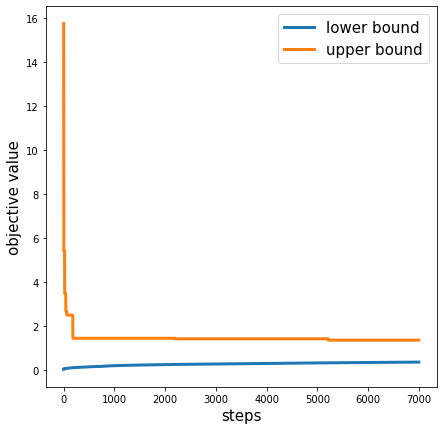

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(7,7))

plt.plot(lb_list, linewidth=3)
plt.plot(ub_list,linewidth=3)
plt.legend(['lower bound', 'upper bound'],fontsize=15)
plt.xlabel('steps', fontsize=15)
plt.ylabel('objective value', fontsize=15)
# plt.legend()


Text(0, 0.5, 'objective value')

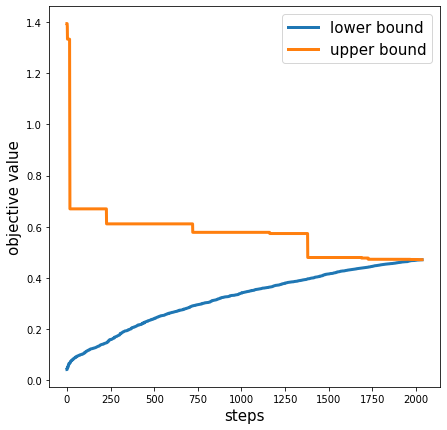

In [3]:
import matplotlib.pyplot as plt

fig2, ax = plt.subplots(1,1, figsize=(7,7))

plt.plot(lb_list, linewidth=3)
plt.plot(ub_list,linewidth=3)
plt.legend(['lower bound', 'upper bound'],fontsize=15)
plt.xlabel('steps', fontsize=15)
plt.ylabel('objective value', fontsize=15)
# plt.legend()

In [4]:
fig2.savefig('n=8,m=12,l=3.pdf')

In [8]:
fig.savefig('n=4,m=12,l=3.pdf')

## Plot of Time taken by BB algorithm for different problem sizes

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time 
from models.gnn_policy import GNNPolicy, GNNNodeSelectionPolicy
from models.fcn_policy import FCNNodeSelectionLinearPolicy
from models.gnn_dataset import get_graph_from_obs
from models.setting import MODEL_PATH
from single_group_as_bm.observation import *
# from single_group_as_bm.solve_relaxation import qp_relaxed, solve_relaxed_with_selected_antennas, cvxpy_relaxed
import numpy.ma as ma

min_bound_gap = 0.01

np.random.seed(seed = 100)


# N = [2, 4, 6, 8] 
# M = [4,8,12,16,32]
# max_ant = [2,4,6]
Ns = [2, 4, 6] 
Ms = [4,8,12,16,32]
Ls = [2,4,6]

combinations = []

for N in Ns:
    for M in Ms:
        for max_ant in Ls:
            if max_ant < N:       
                combinations.append((N,M,max_ant))
combinations.append((8,12,6))

result = []
for (N,M,max_ant) in combinations:
    u_avg = 0
    t_avg = 0
    tstep_avg = 0
    for i in range(5):
        H = np.random.randn(N, M) + 1j*np.random.randn(N,M)    
        instance = np.stack((np.real(H), np.imag(H)), axis=0)
        z_inc, global_U, timesteps, t= solve_bb(instance, max_ant=max_ant, max_iter = 7000)
        u_avg += global_U
        t_avg += t
        tstep_avg += timesteps
    result.append((N,M,maxant, u_avg, t_avg, tstep_avg))
    print(N,M,maxant, u_avg, t_avg, tstep_avg)

In [10]:
Ns = [2, 4, 6, 8] 
Ms = [4,8,12,16,32]
Ls = [2,4,6]

combinations = []

for N in range(Ns):
    for M in range(Ms):
        for max_ant in range(Ls):
            if max_ant < N:
                combinations.append((N,M,max_ant))
            

TypeError: 'list' object cannot be interpreted as an integer

## Ogap and acceleration obtained for different problem sizes